In [2]:
import os
from os.path import exists, join

import matplotlib.animation as animation
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
import ffmpeg
from matplotlib.animation import FuncAnimation

pd.options.mode.chained_assignment = None  # default='warn'

Shape of video array: (200, 2, 29, 31)


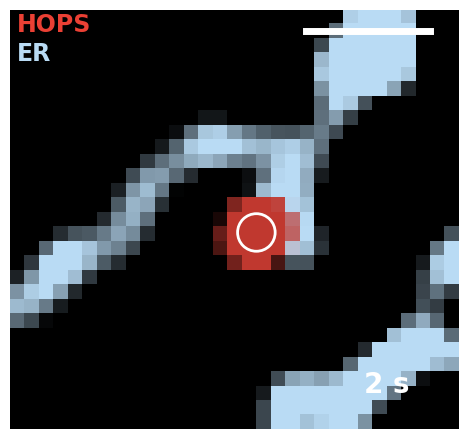

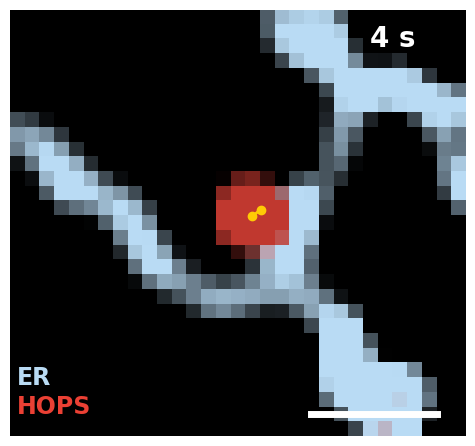

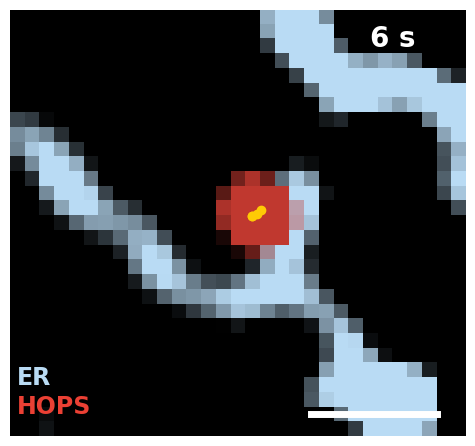

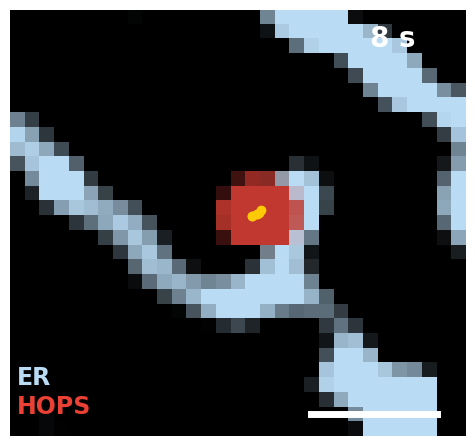

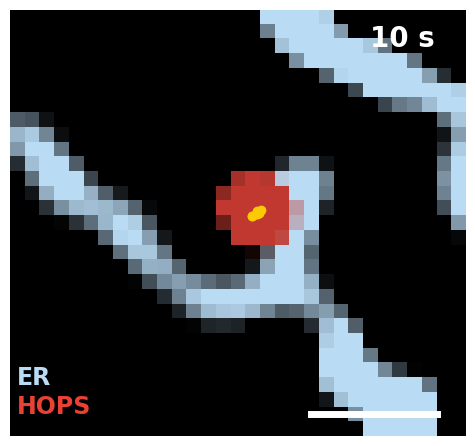

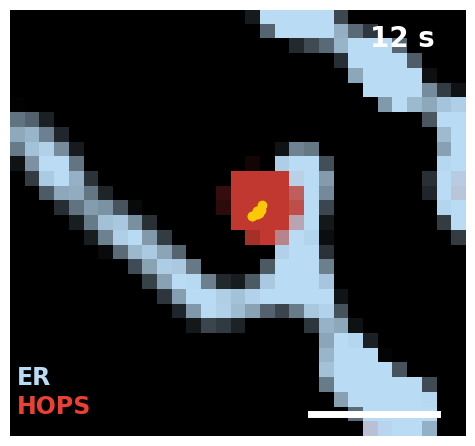

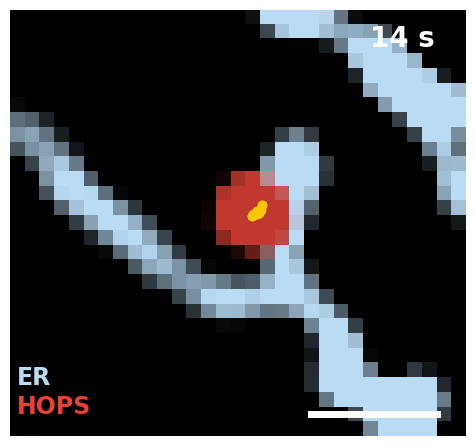

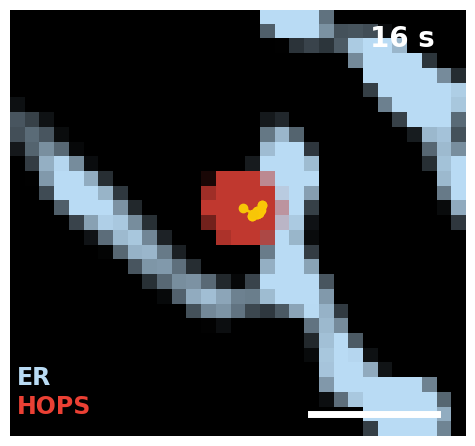

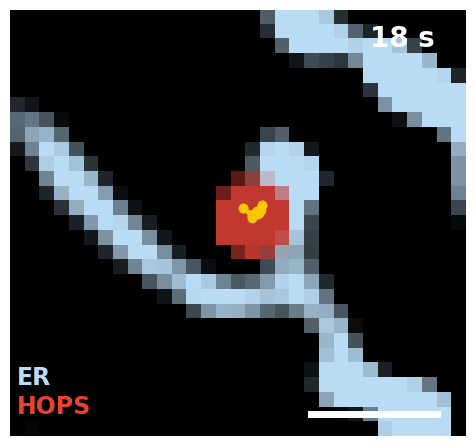

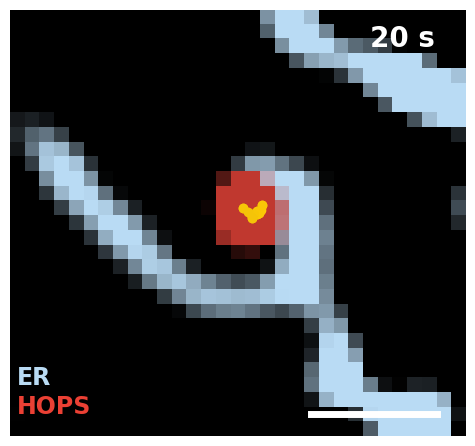

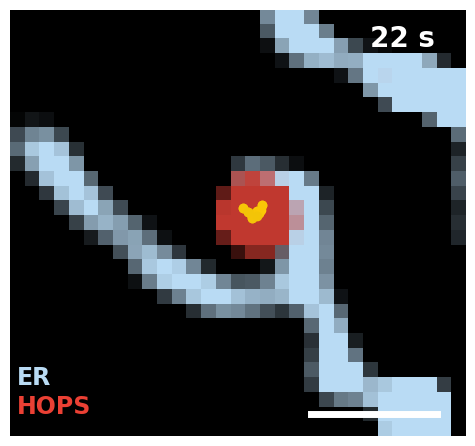

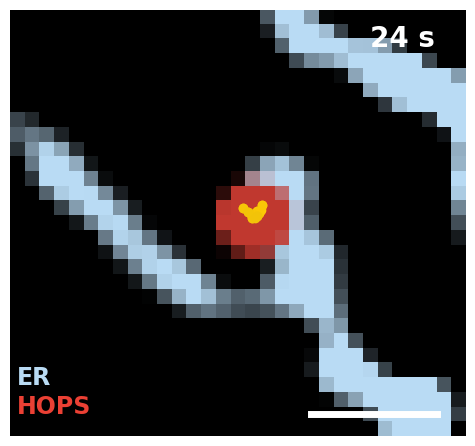

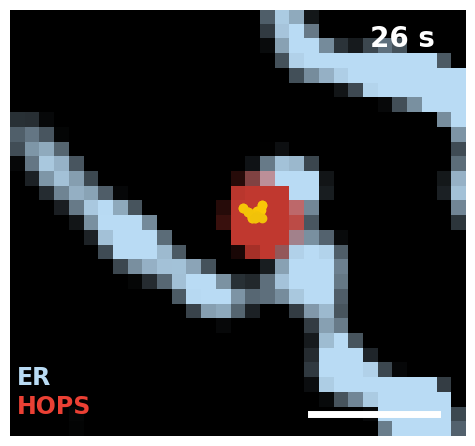

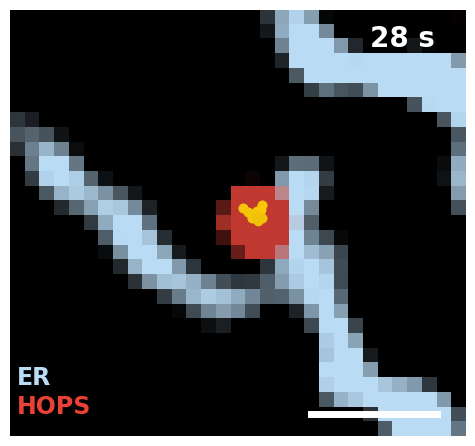

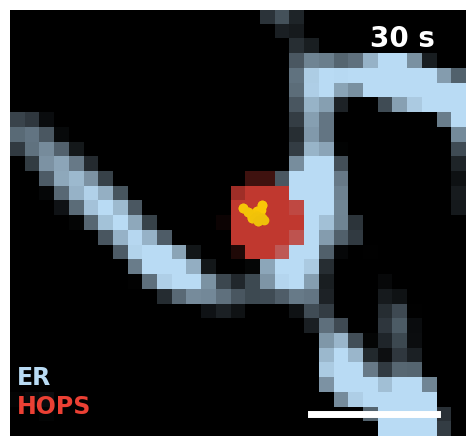

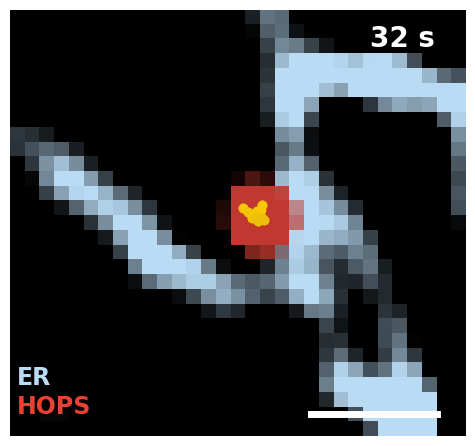

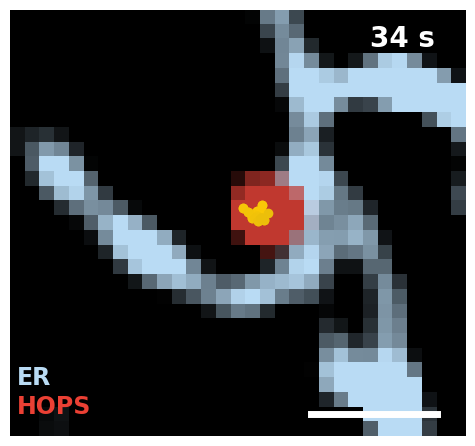

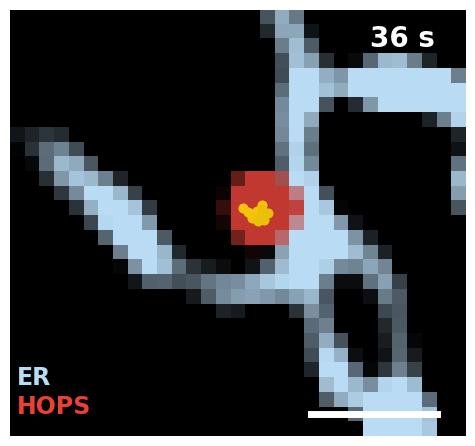

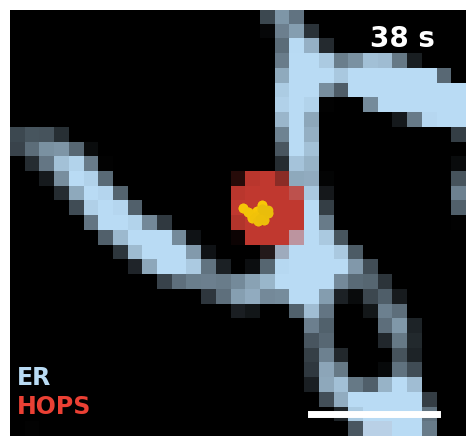

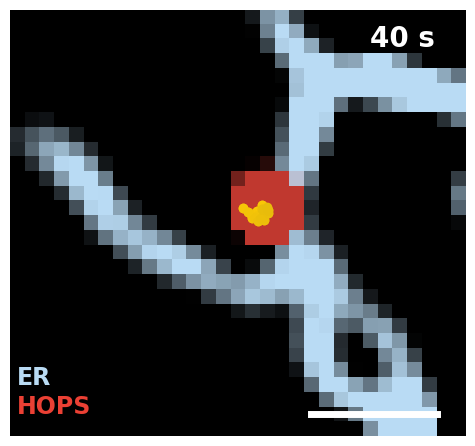

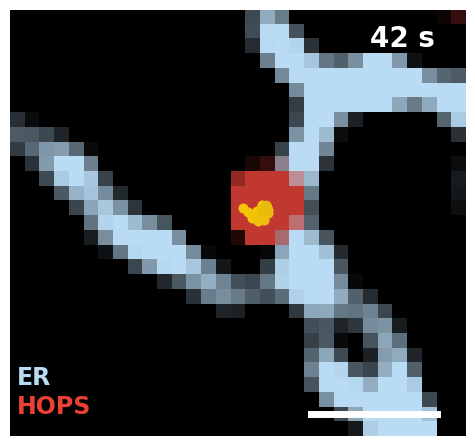

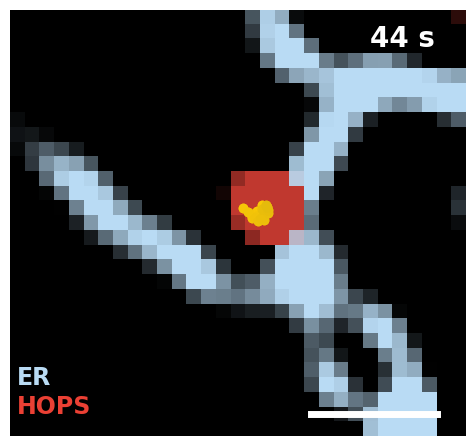

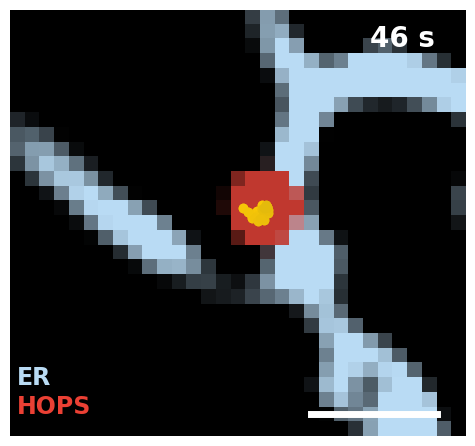

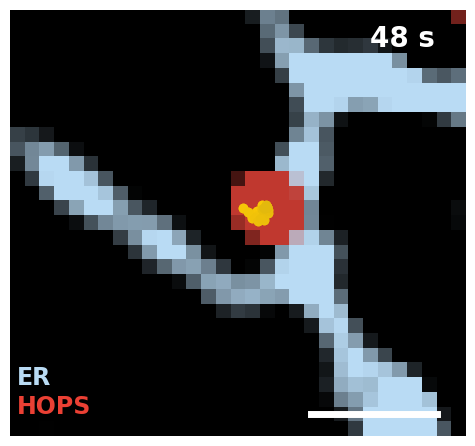

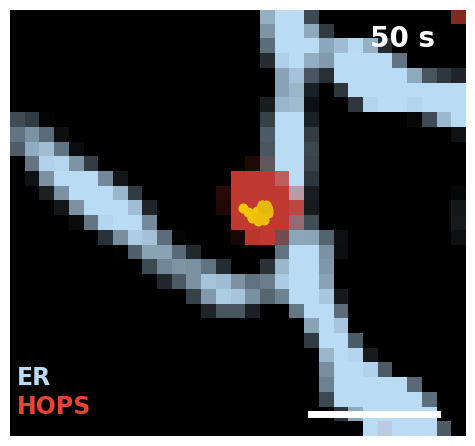

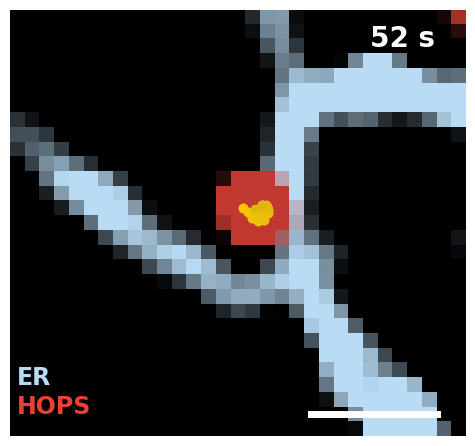

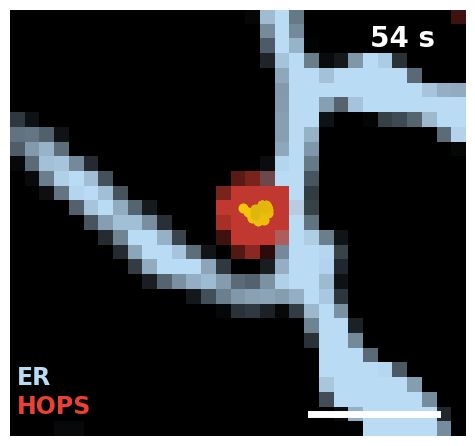

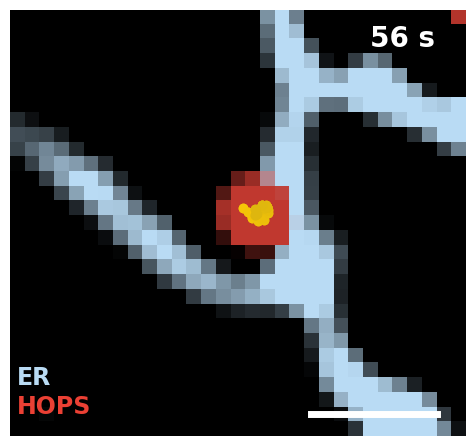

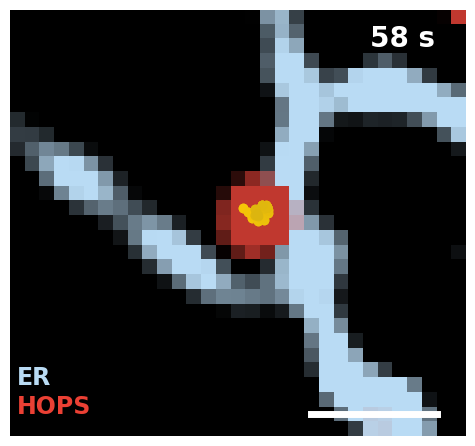

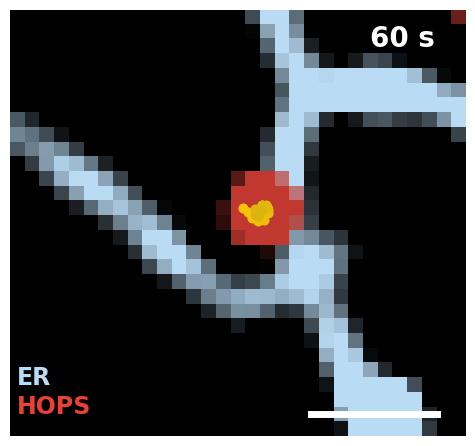

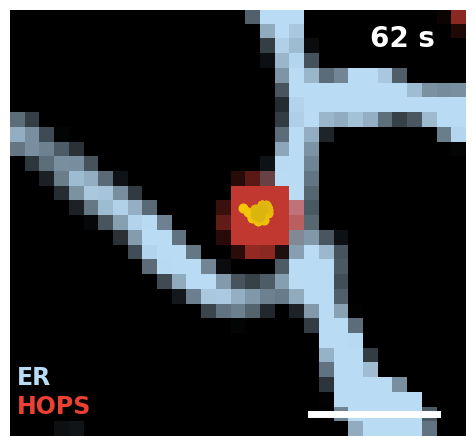

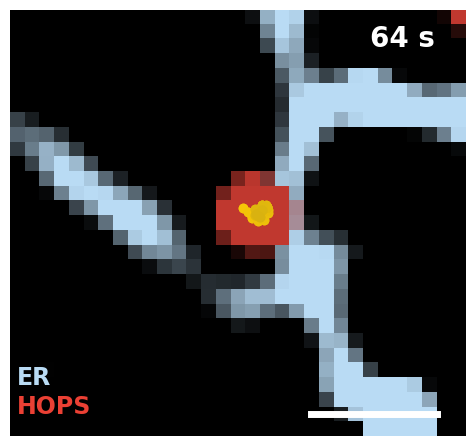

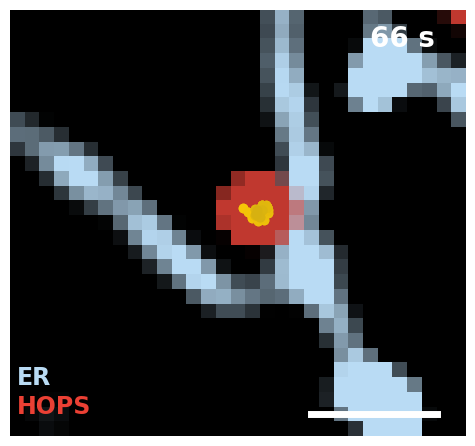

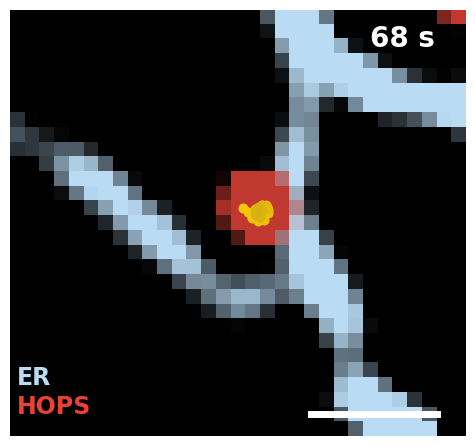

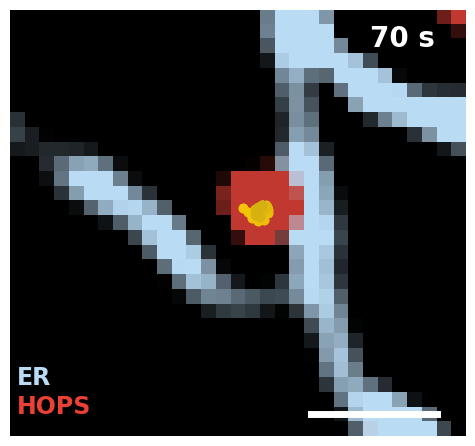

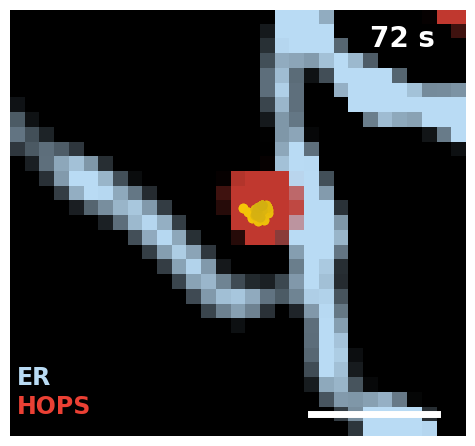

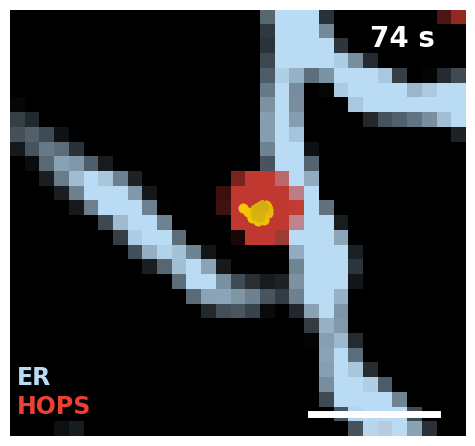

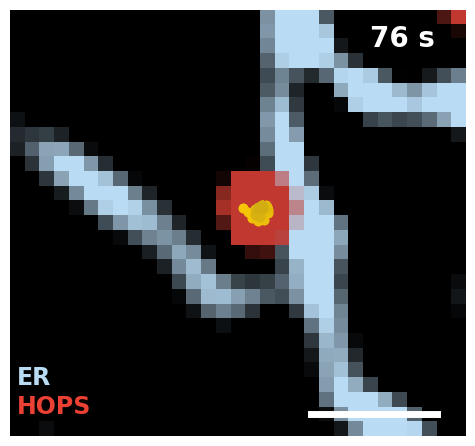

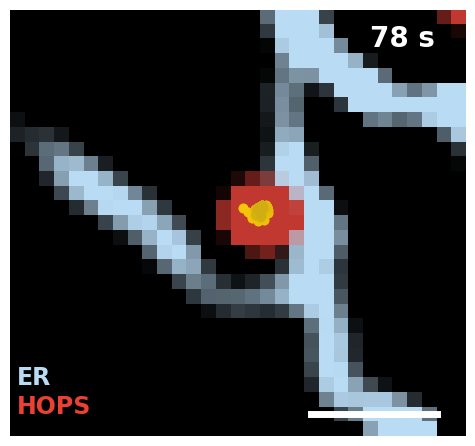

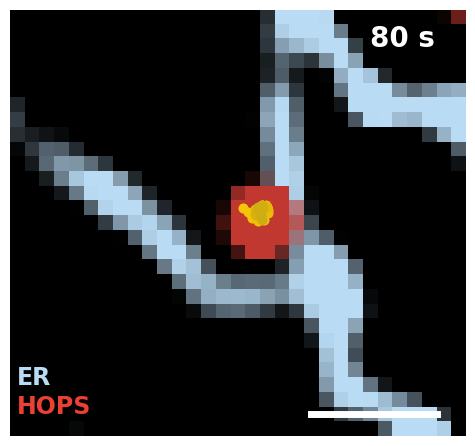

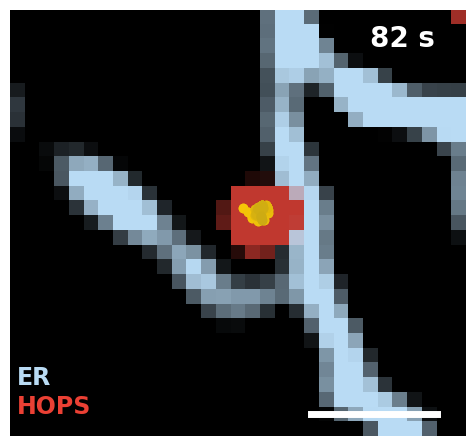

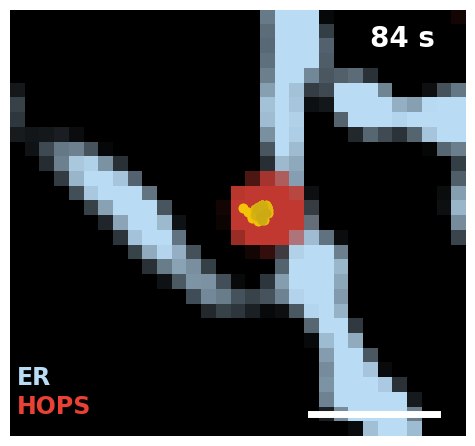

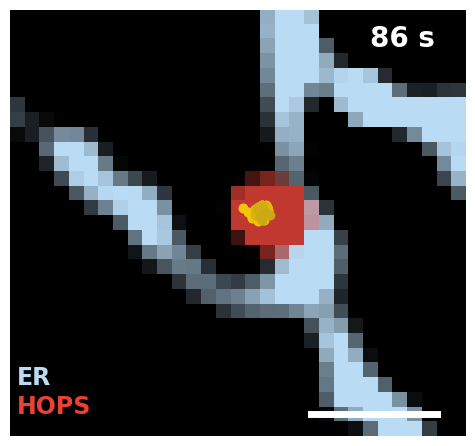

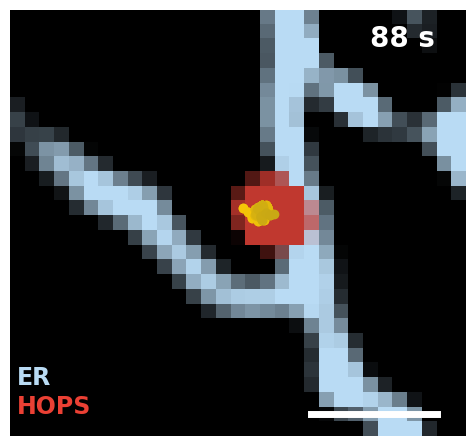

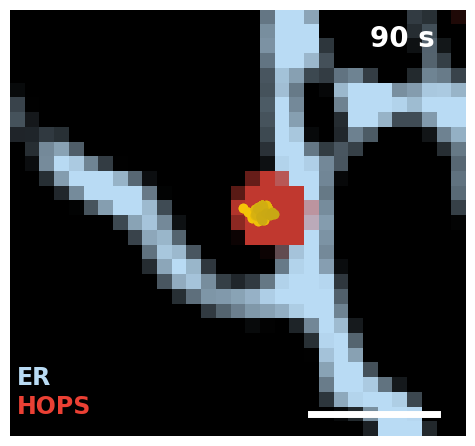

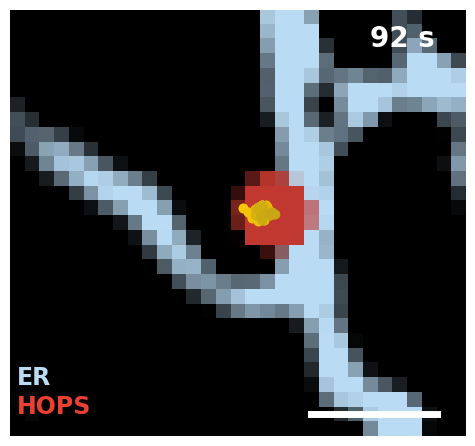

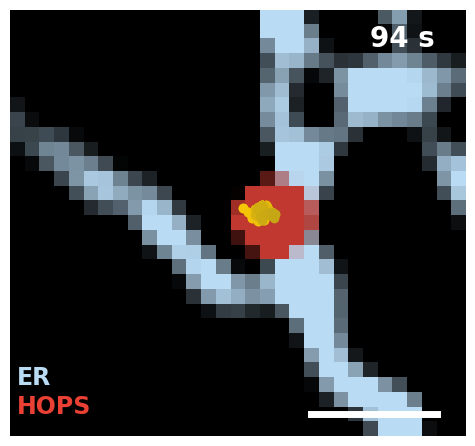

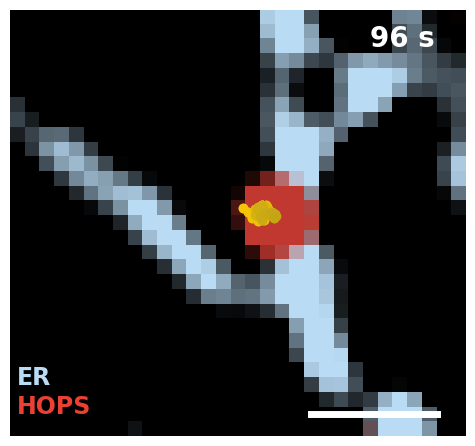

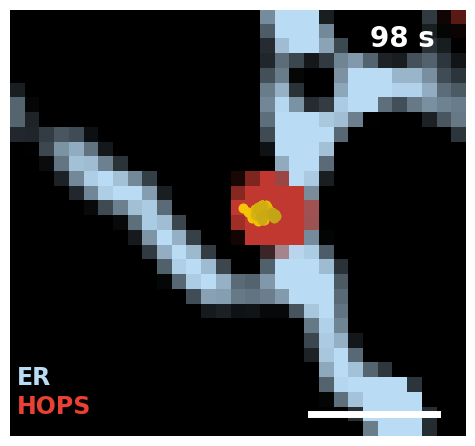

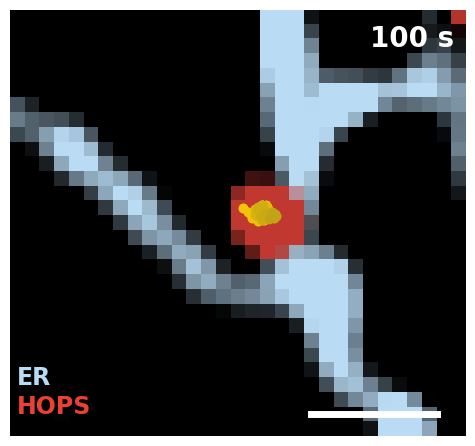

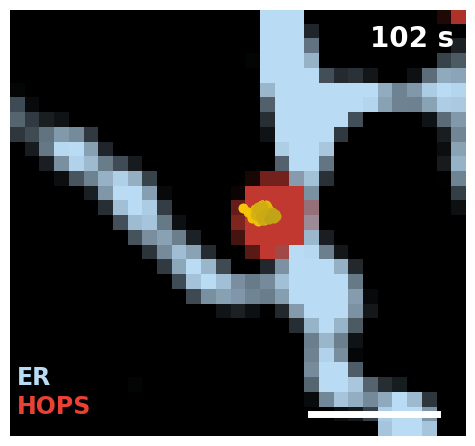

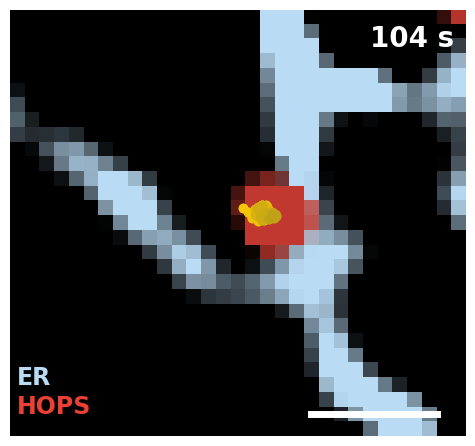

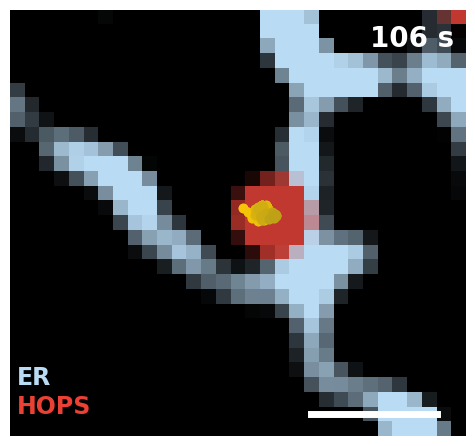

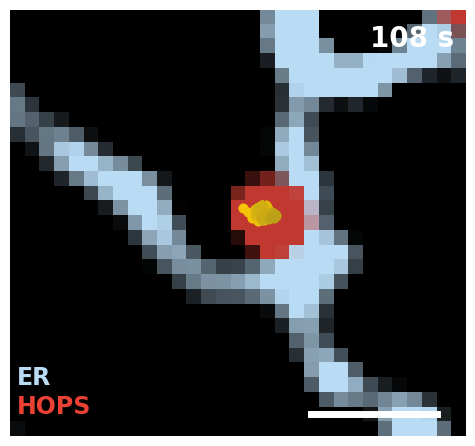

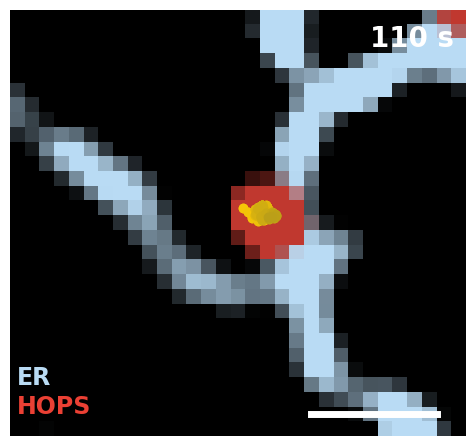

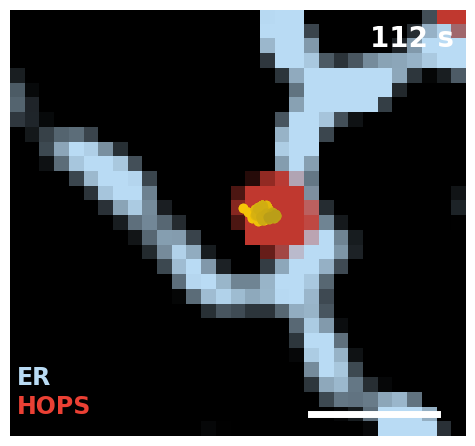

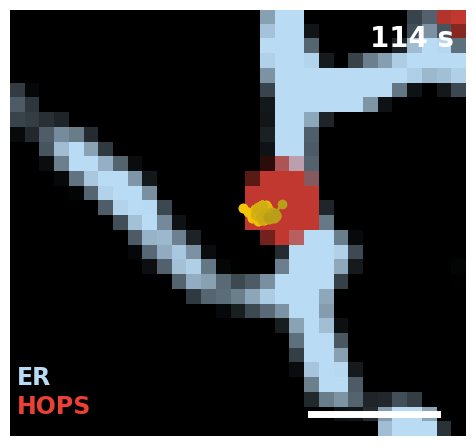

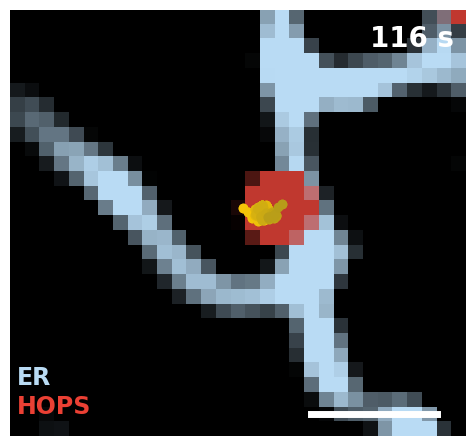

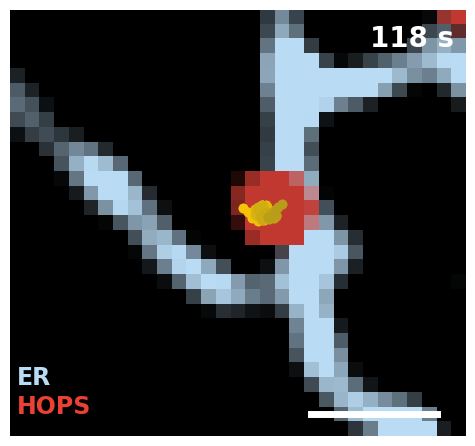

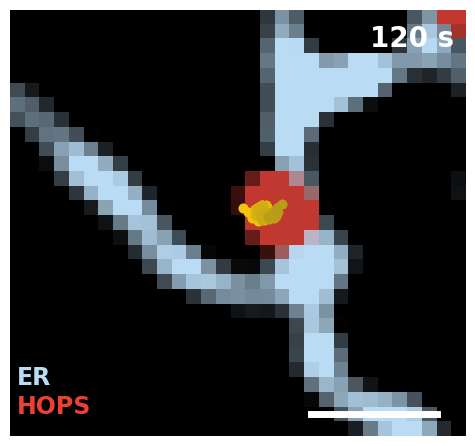

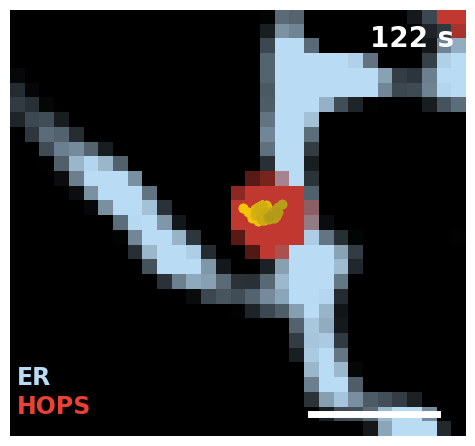

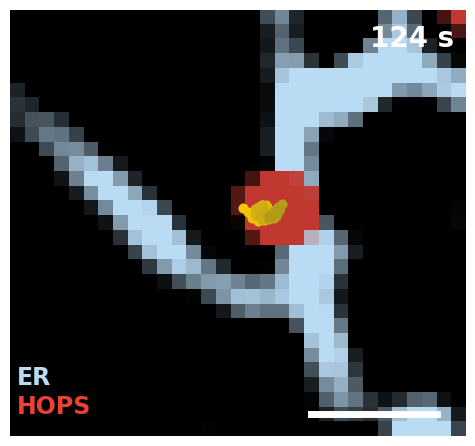

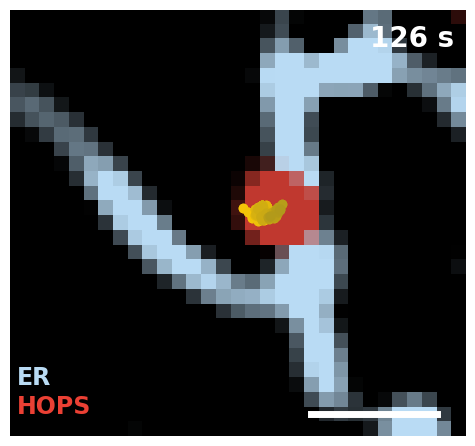

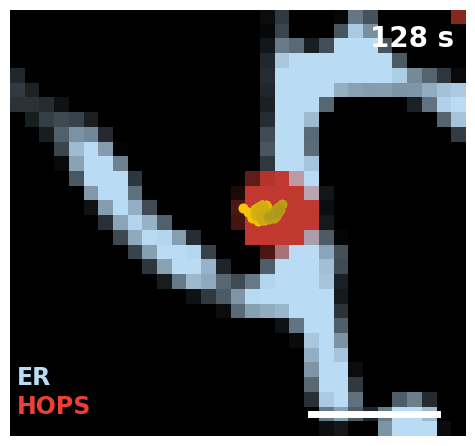

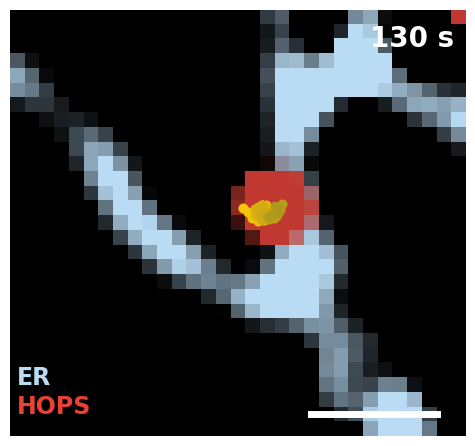

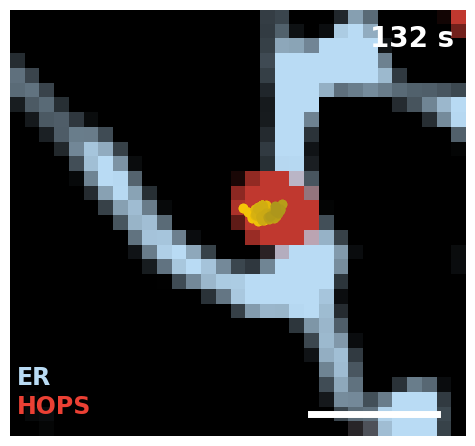

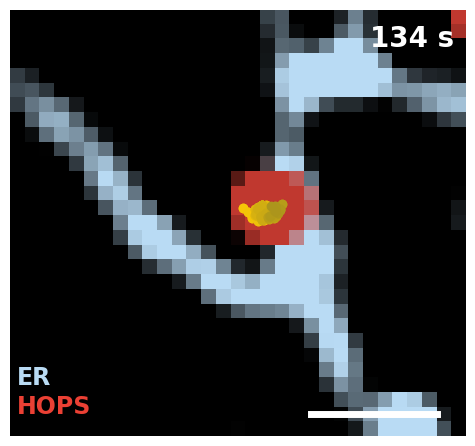

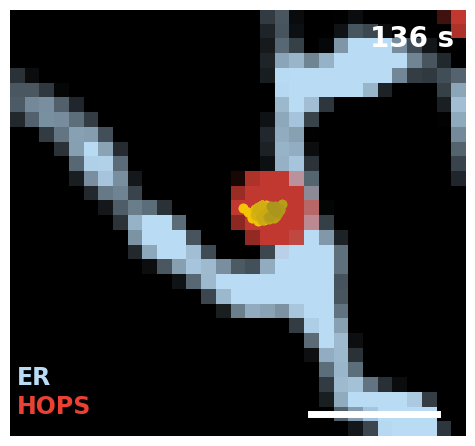

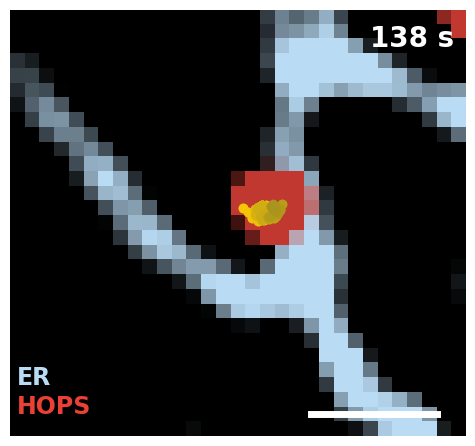

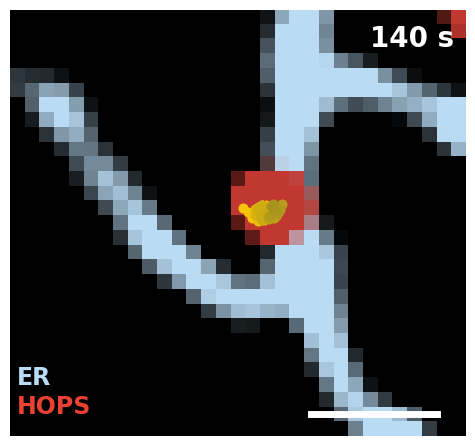

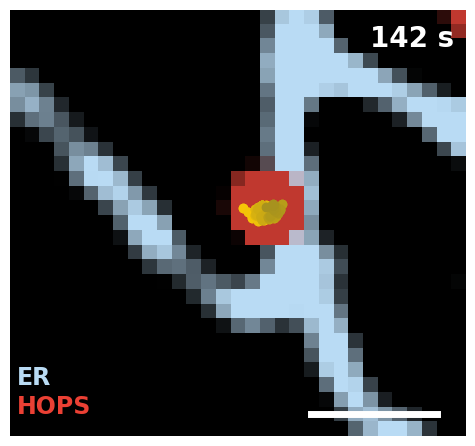

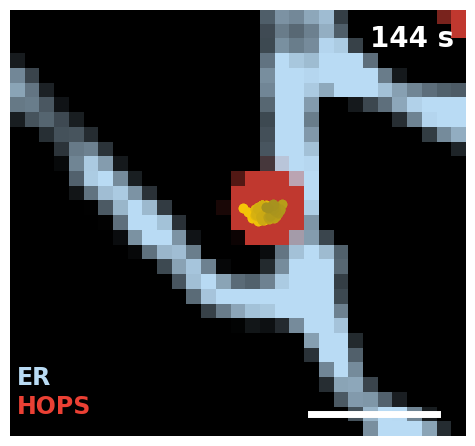

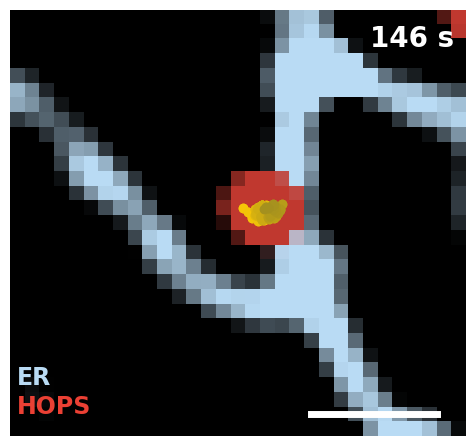

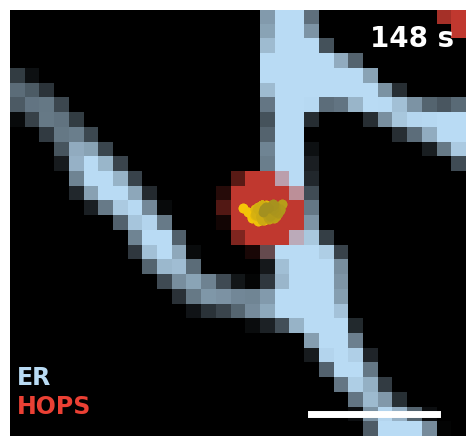

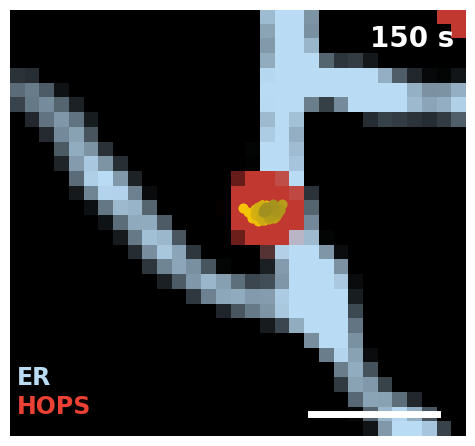

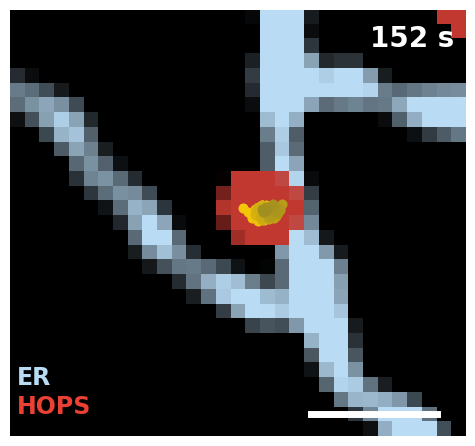

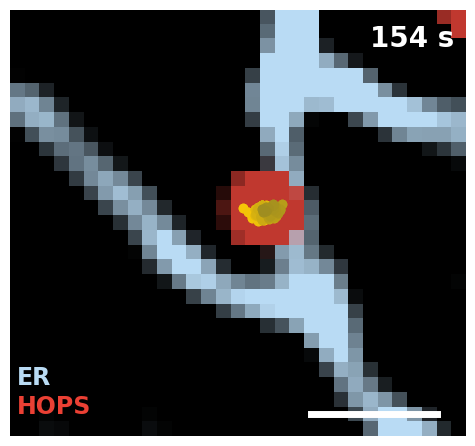

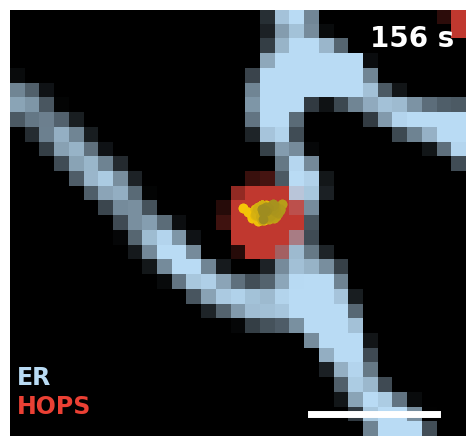

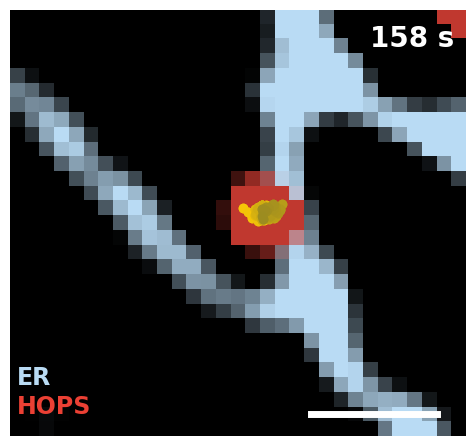

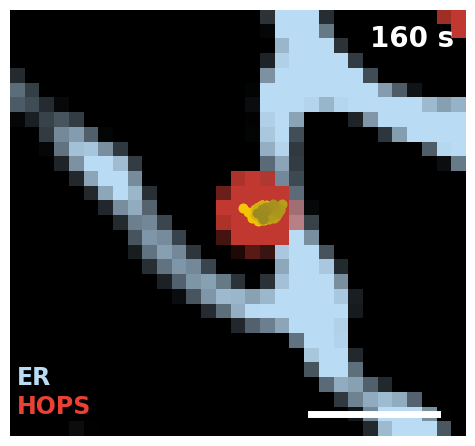

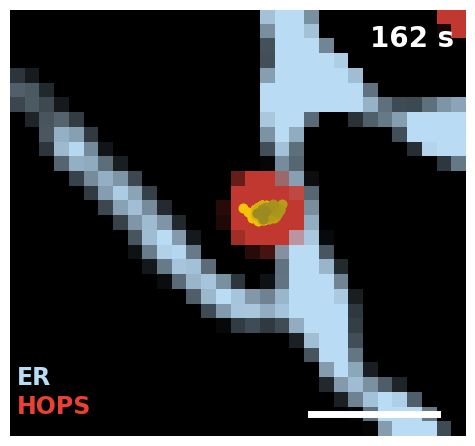

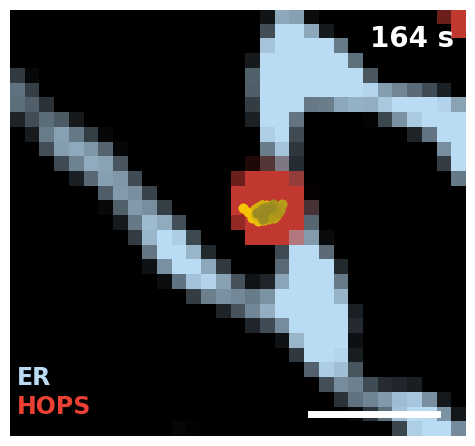

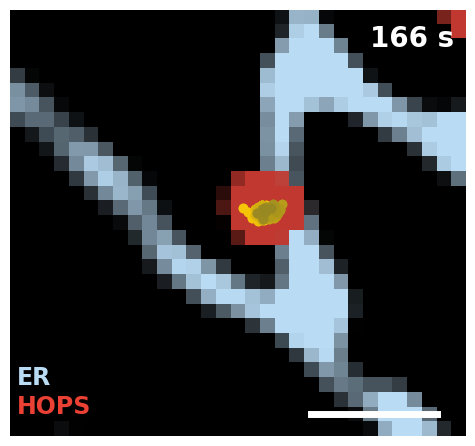

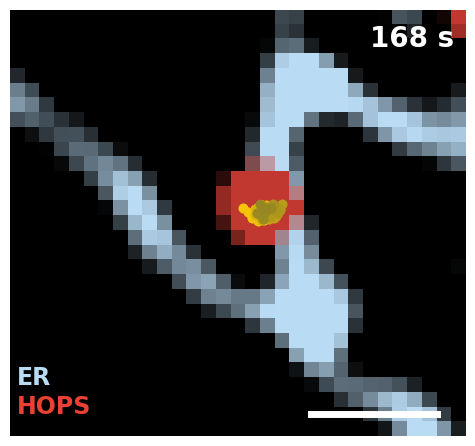

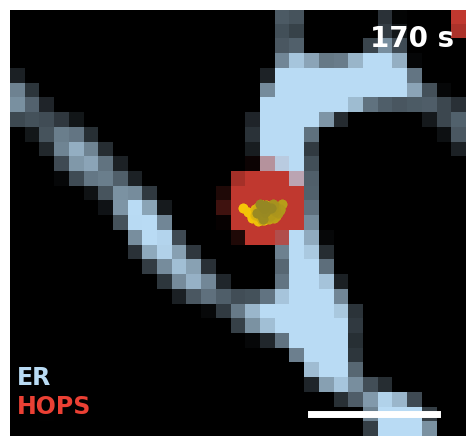

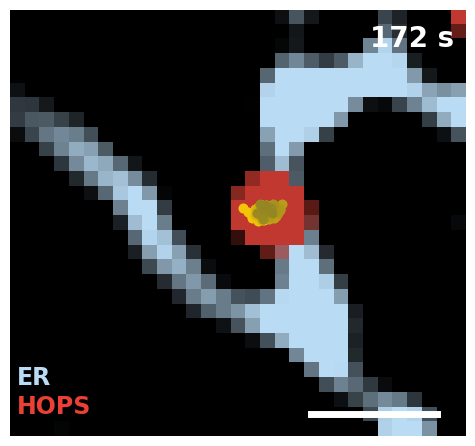

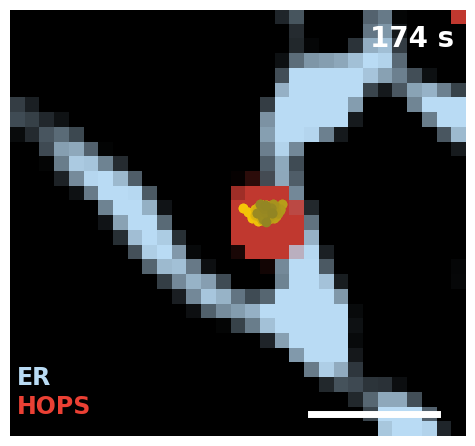

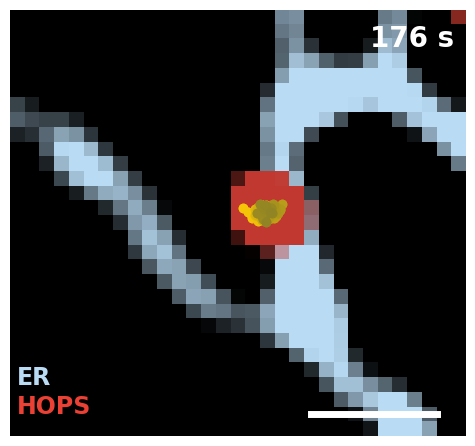

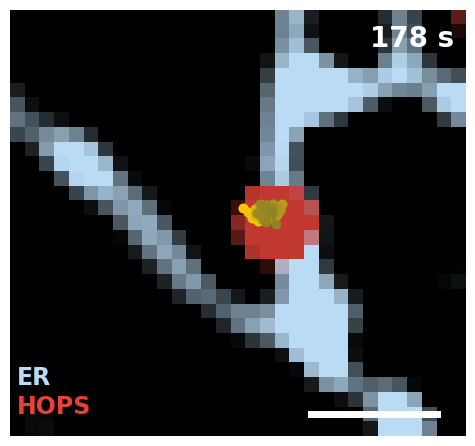

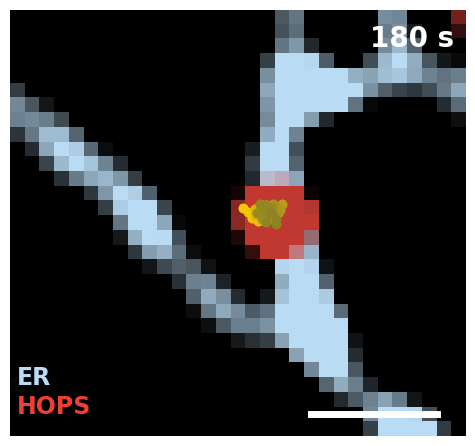

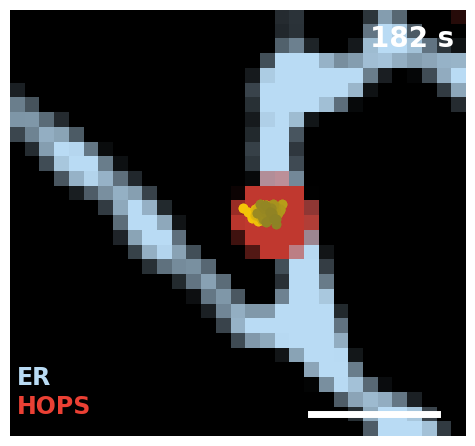

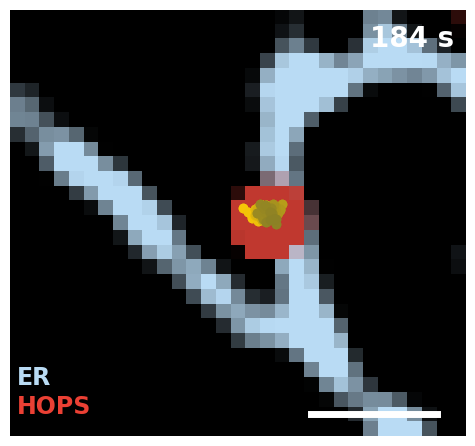

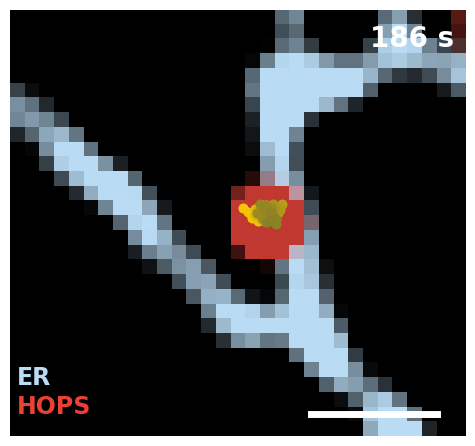

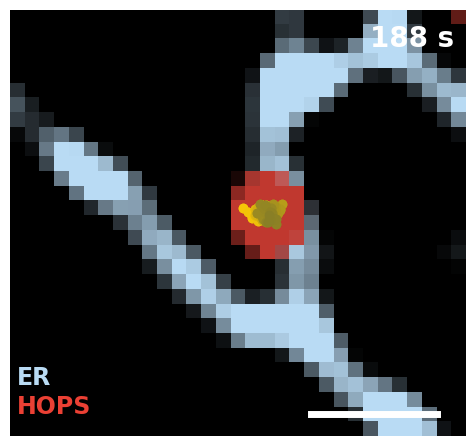

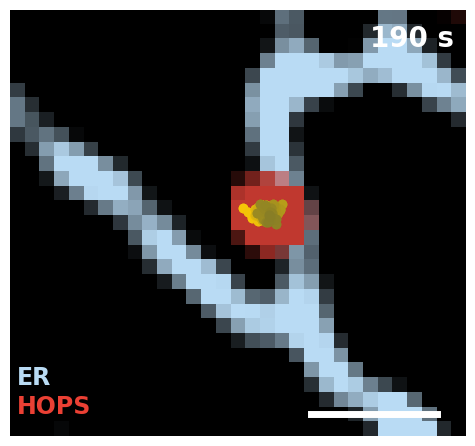

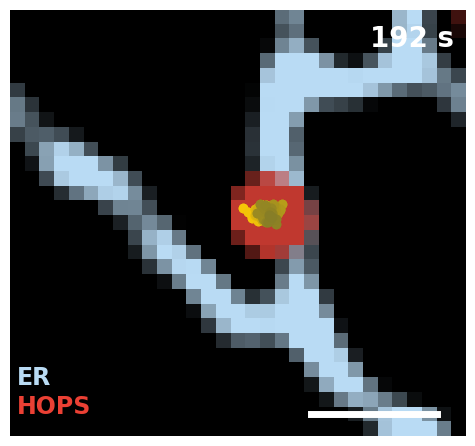

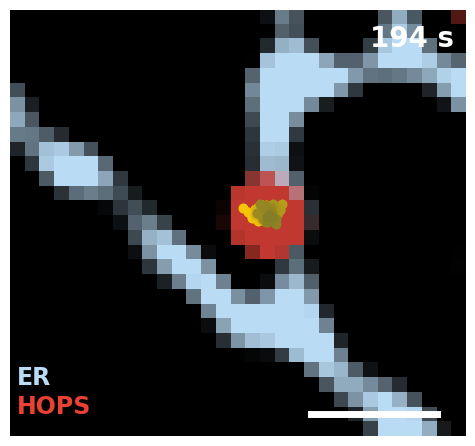

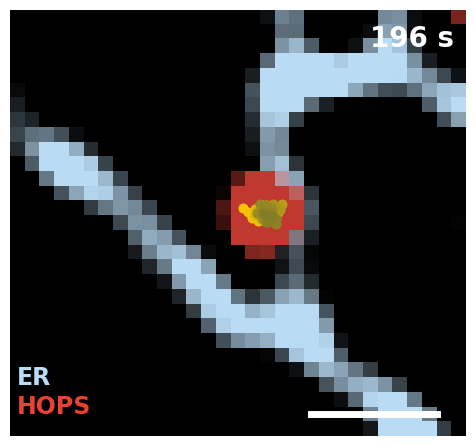

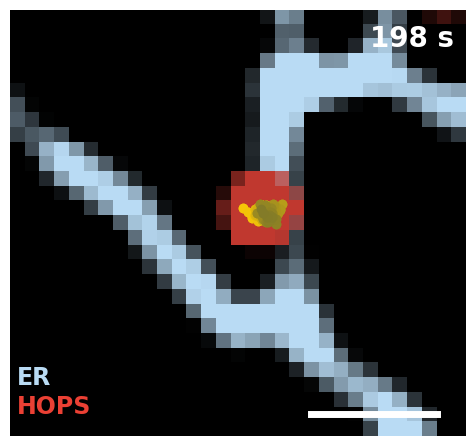

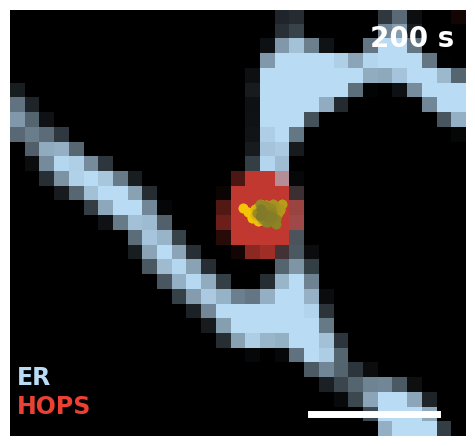

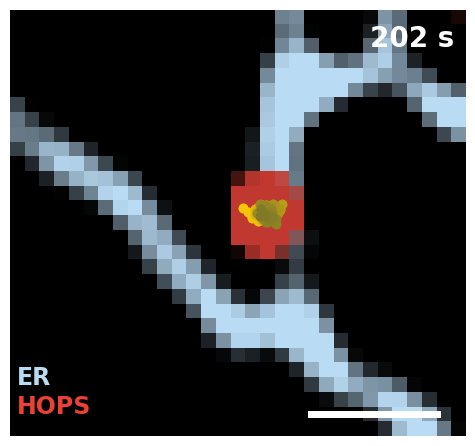

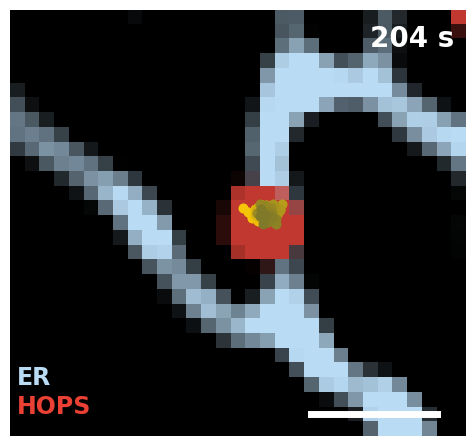

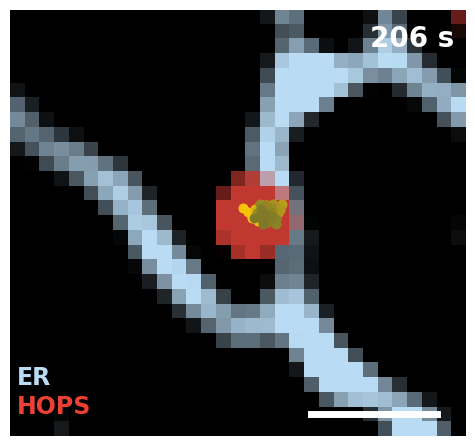

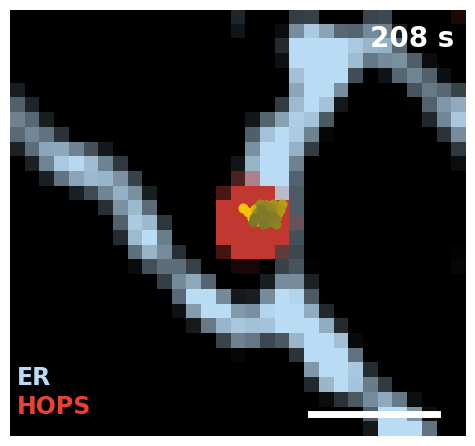

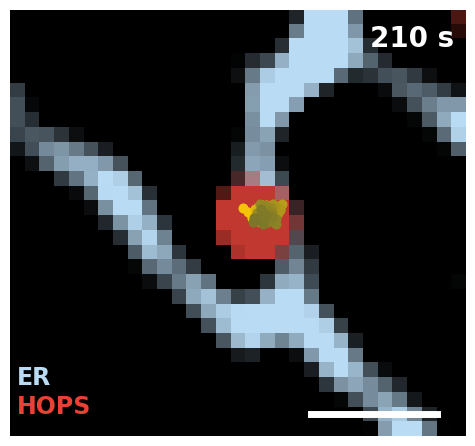

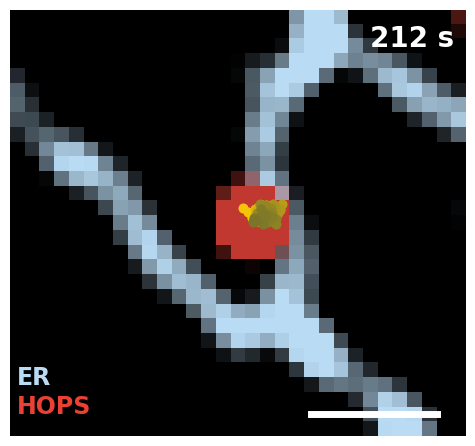

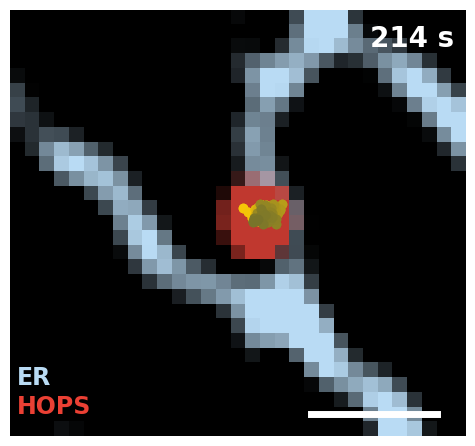

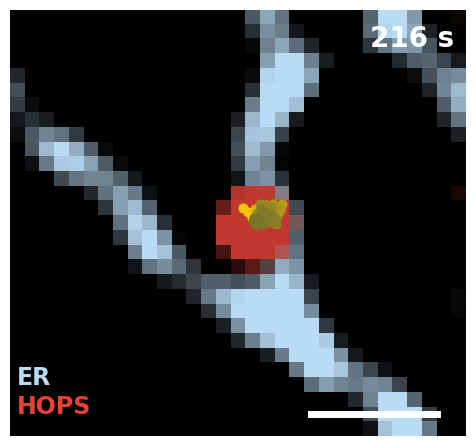

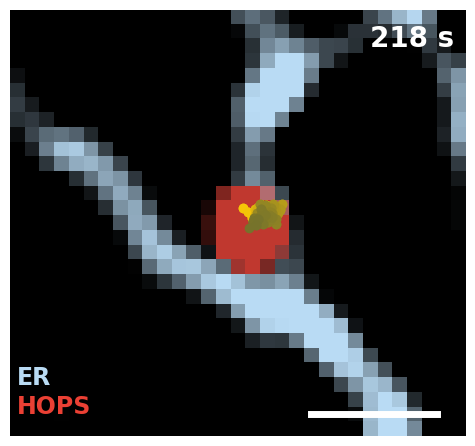

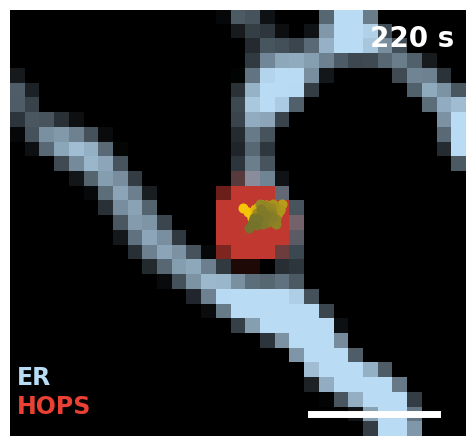

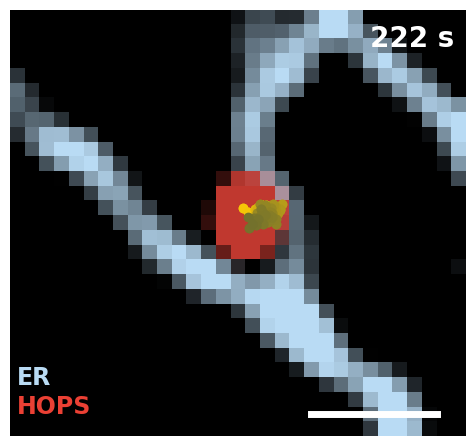

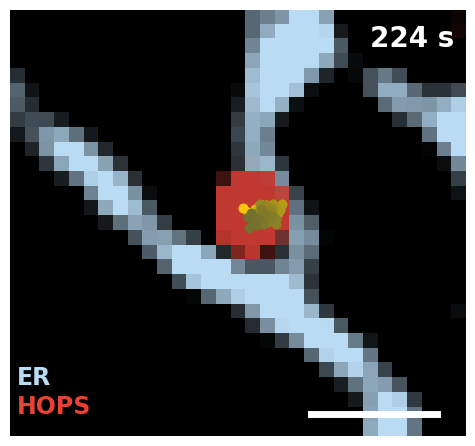

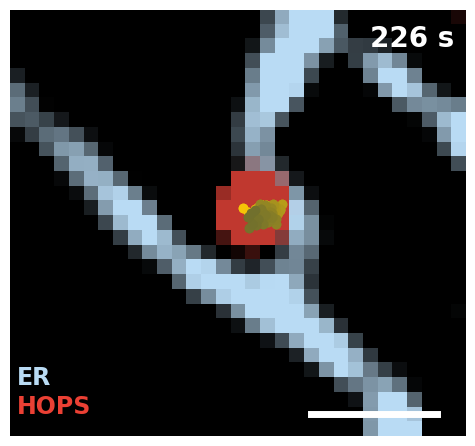

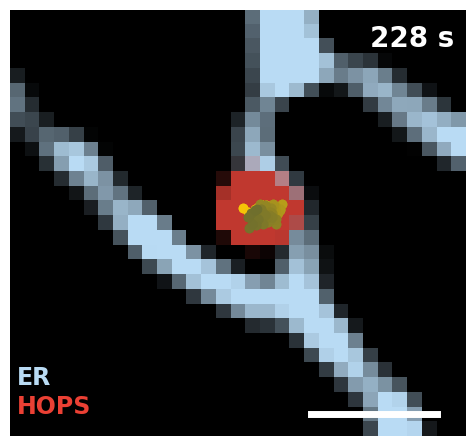

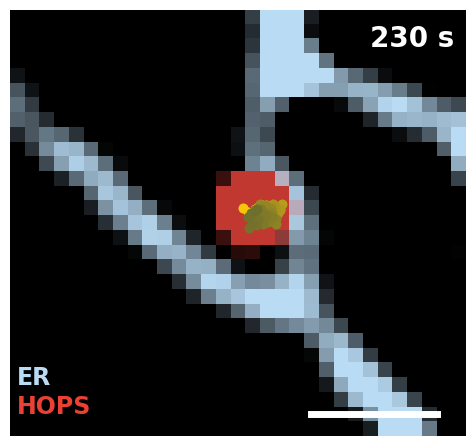

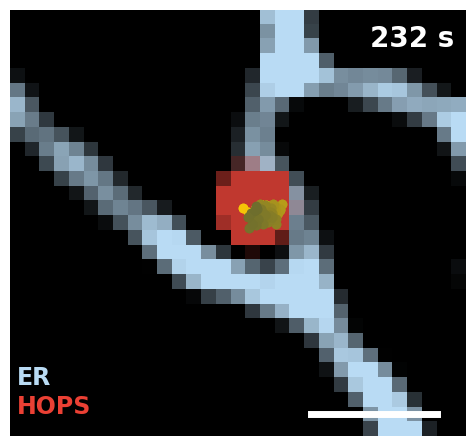

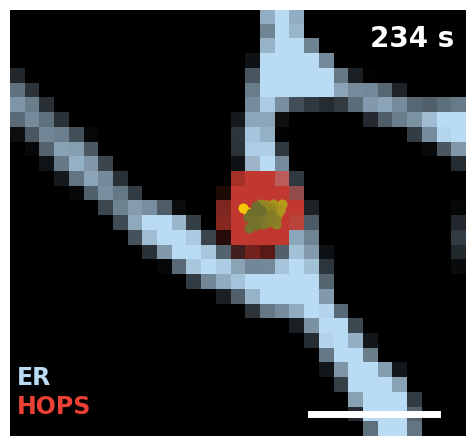

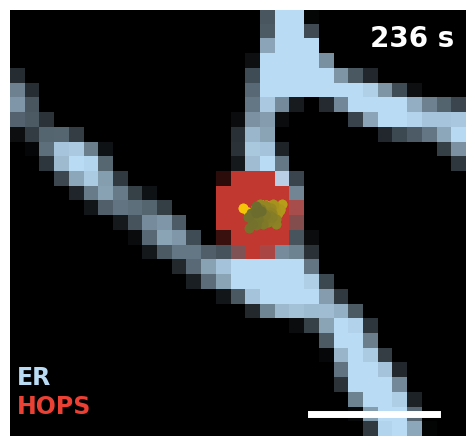

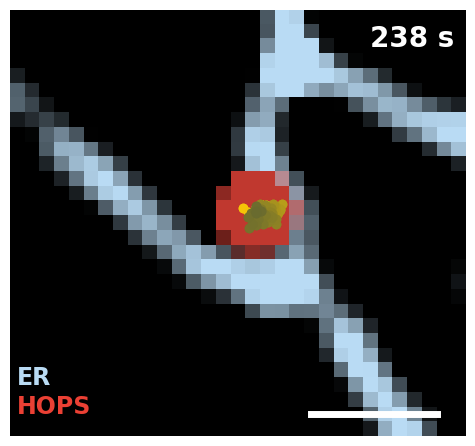

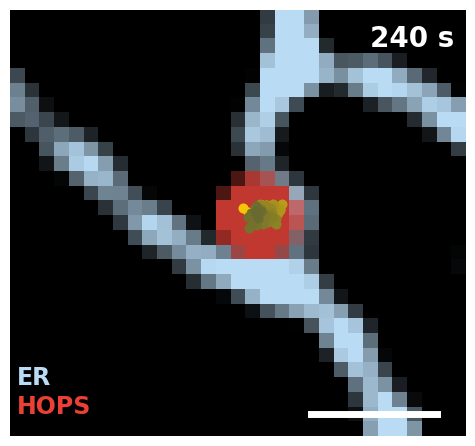

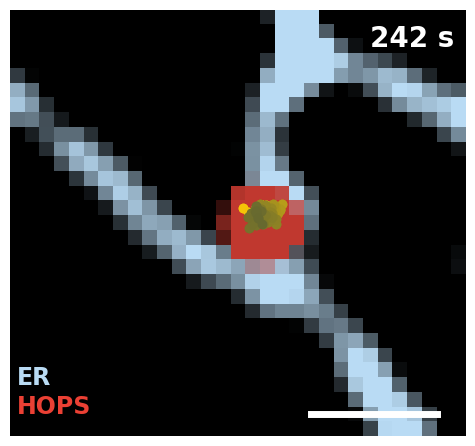

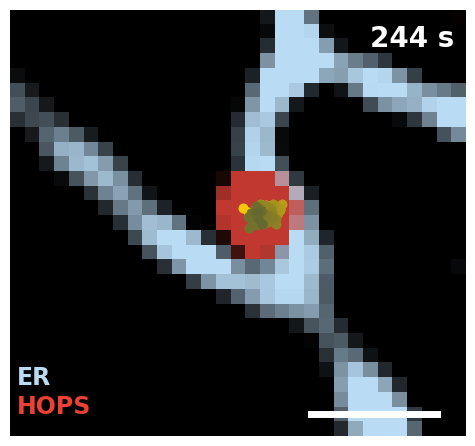

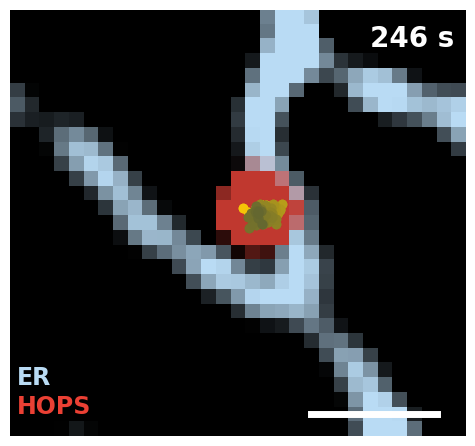

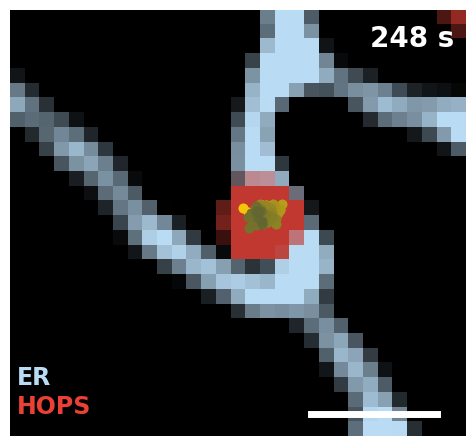

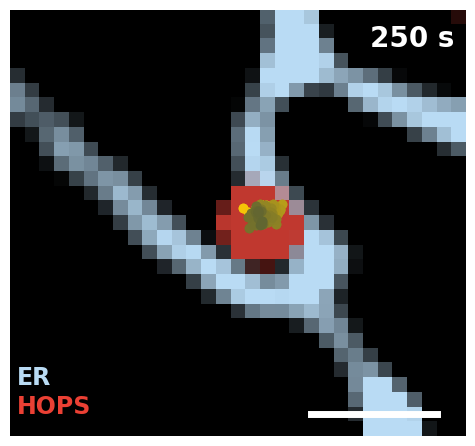

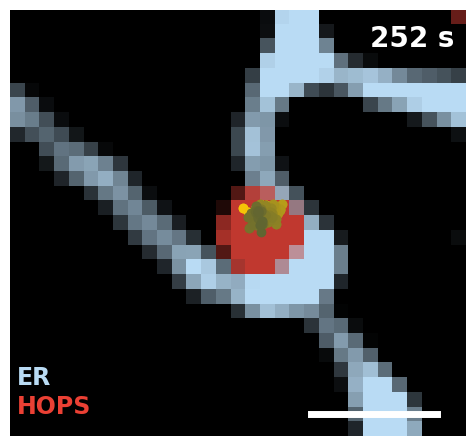

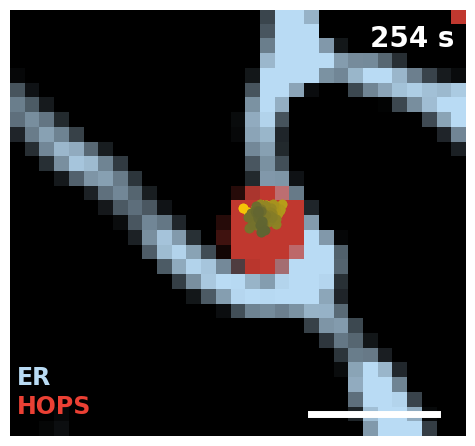

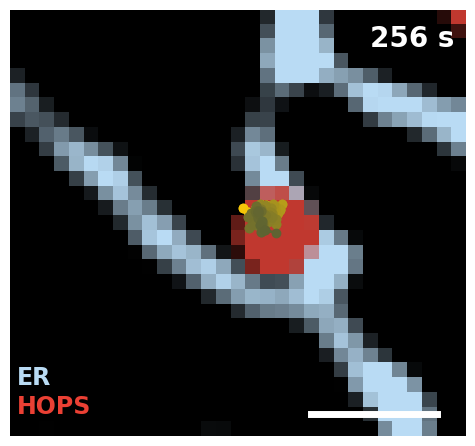

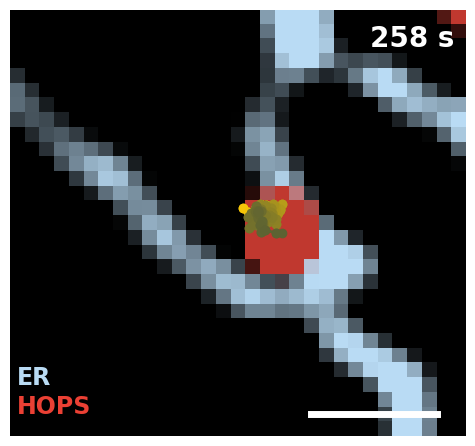

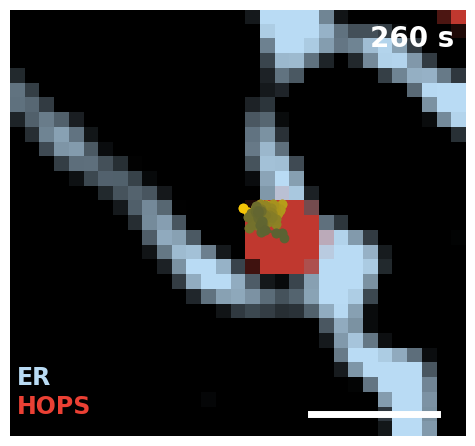

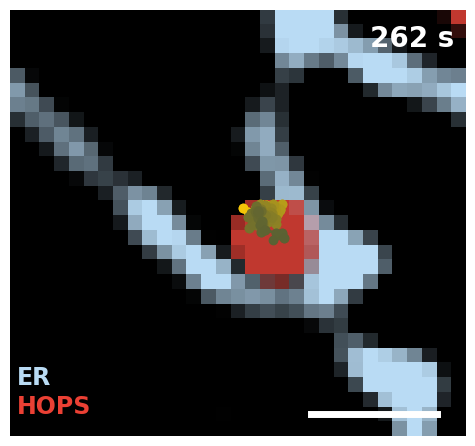

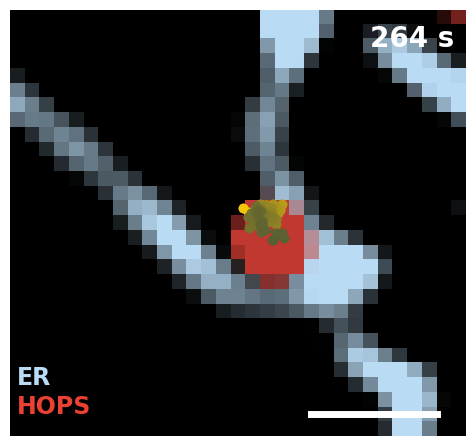

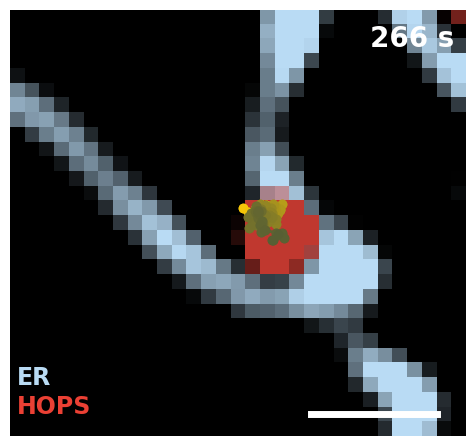

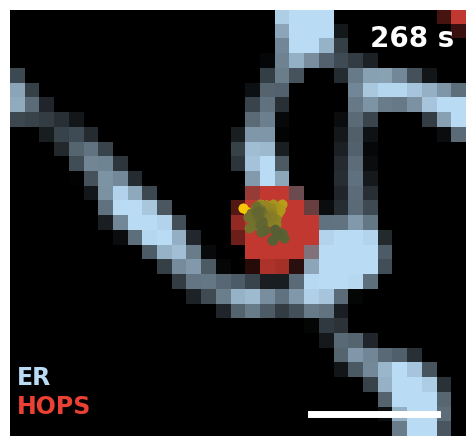

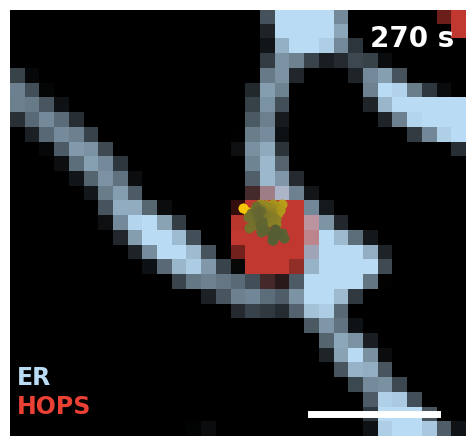

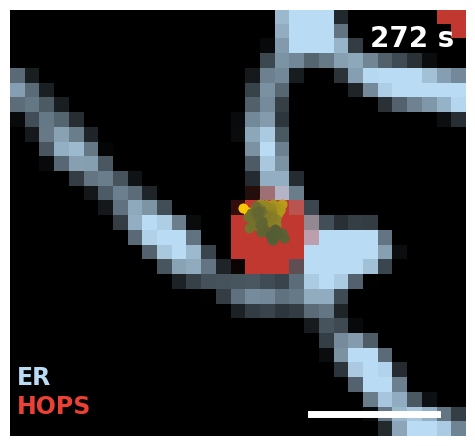

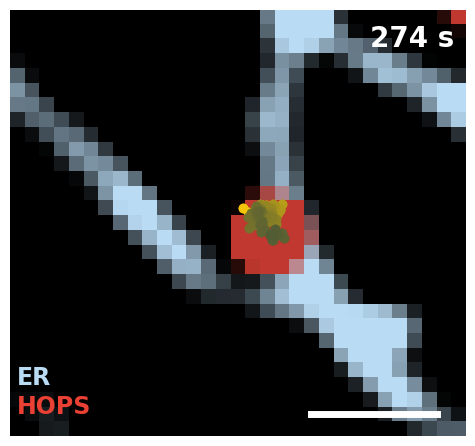

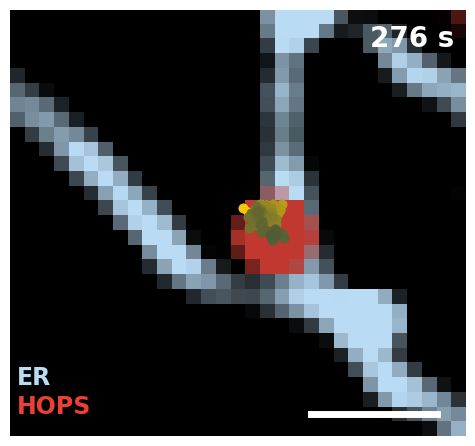

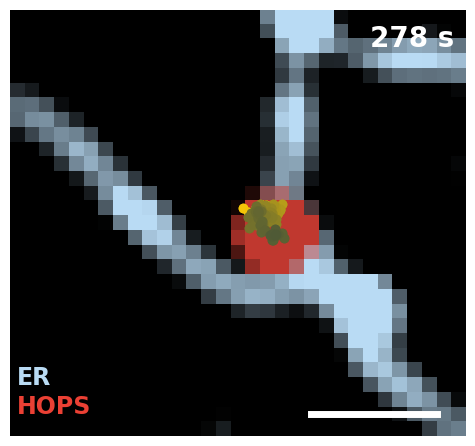

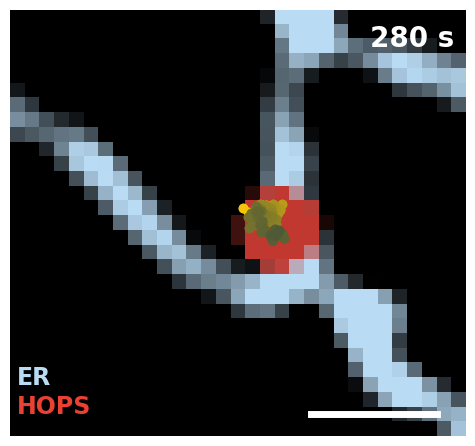

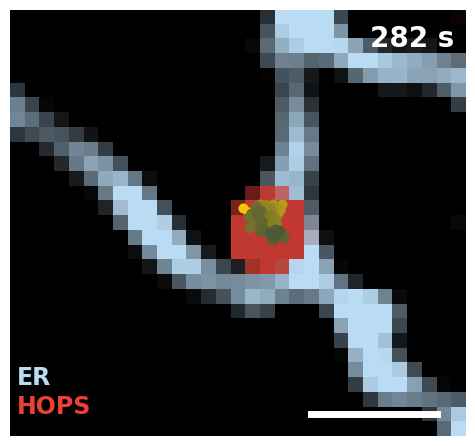

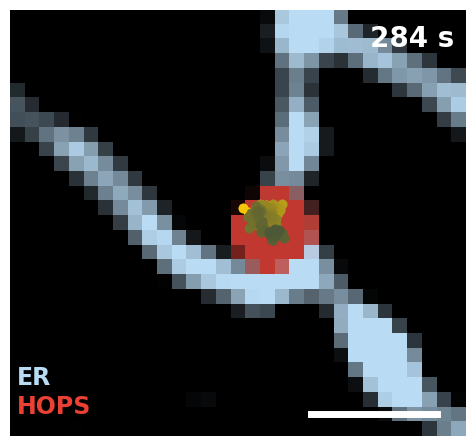

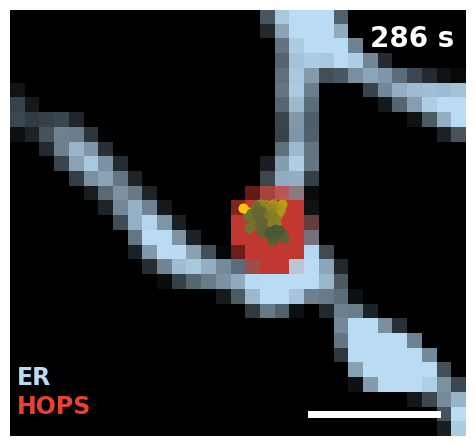

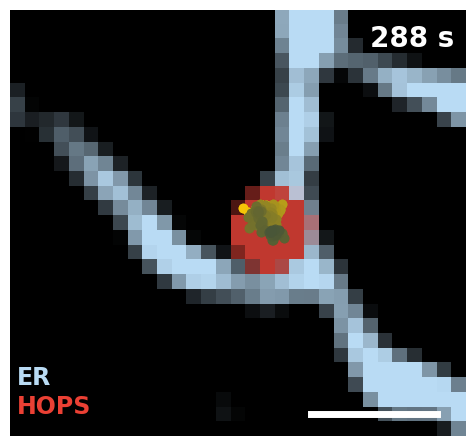

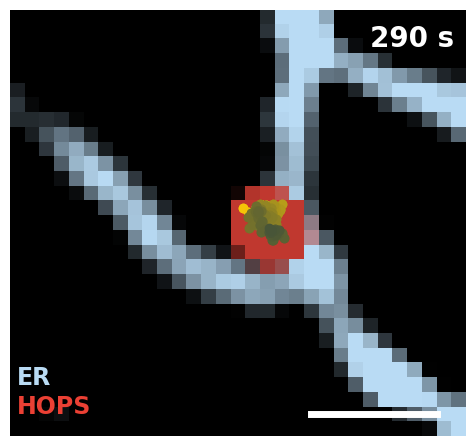

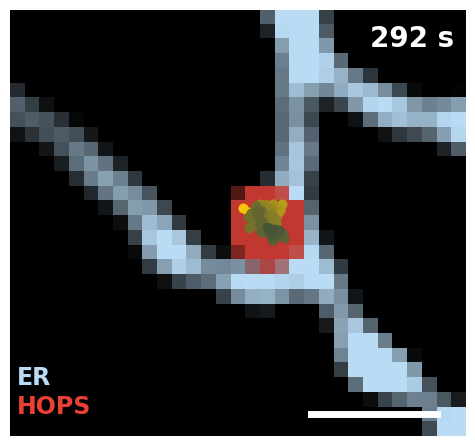

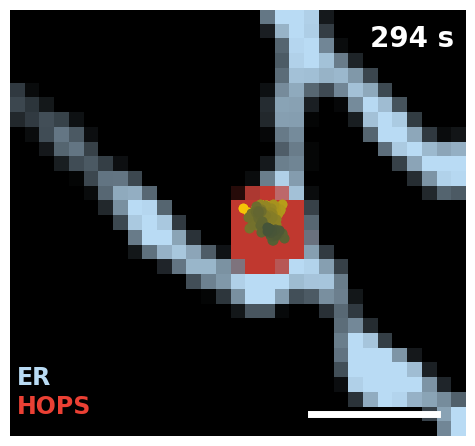

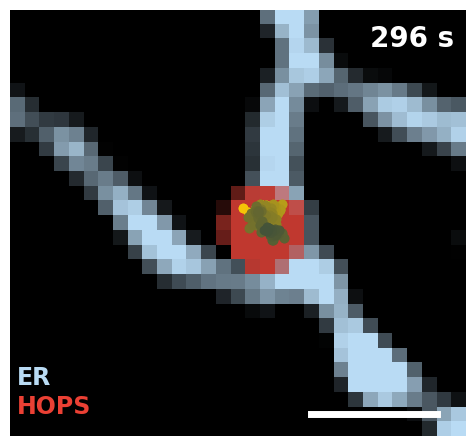

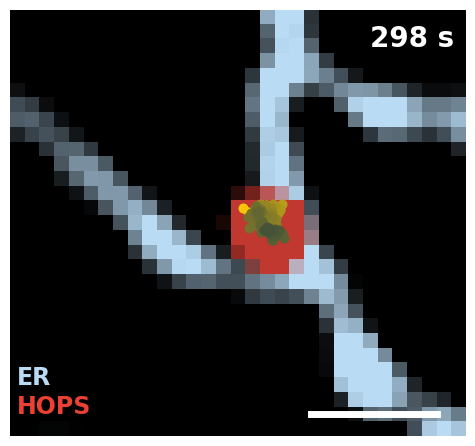

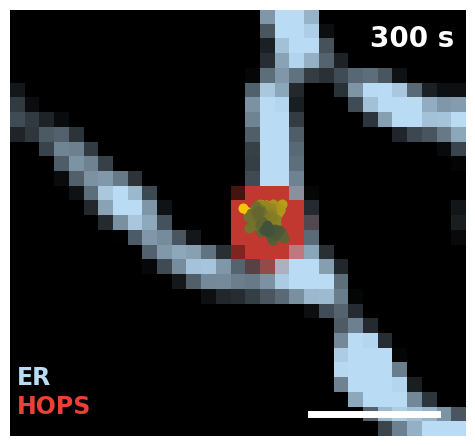

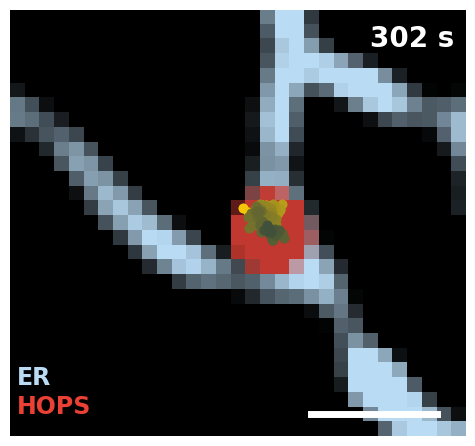

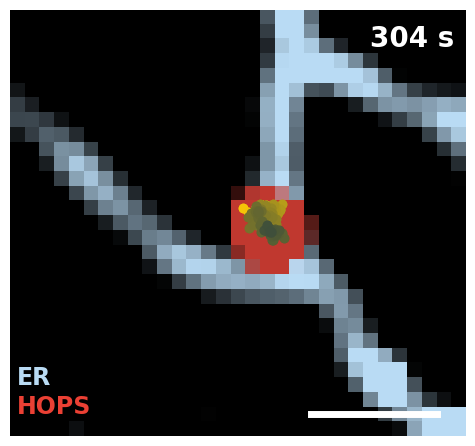

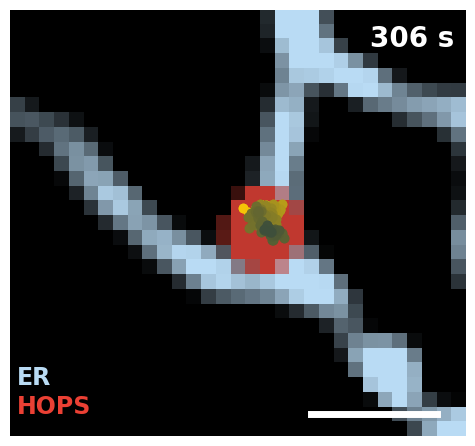

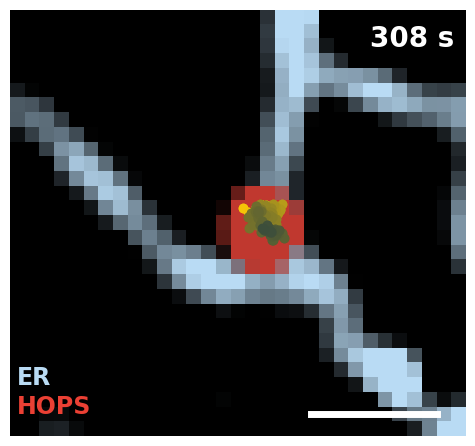

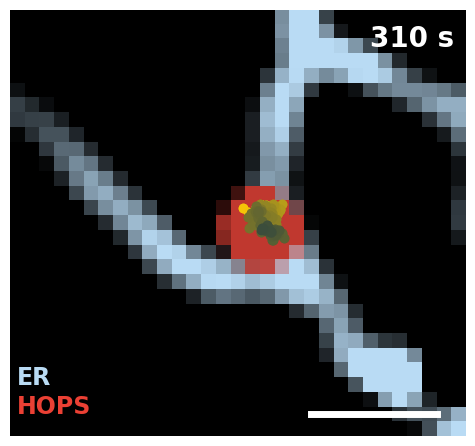

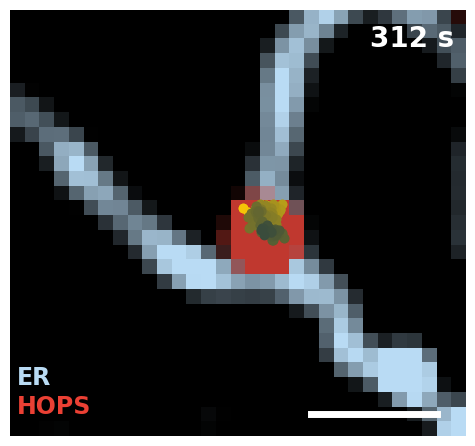

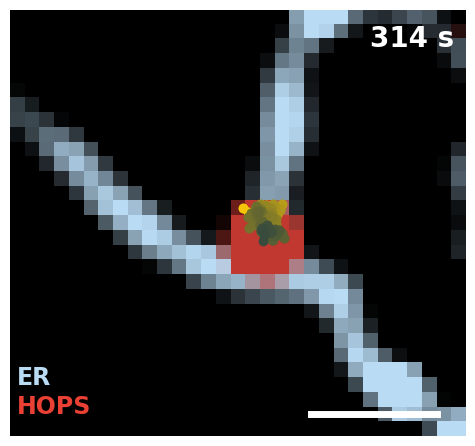

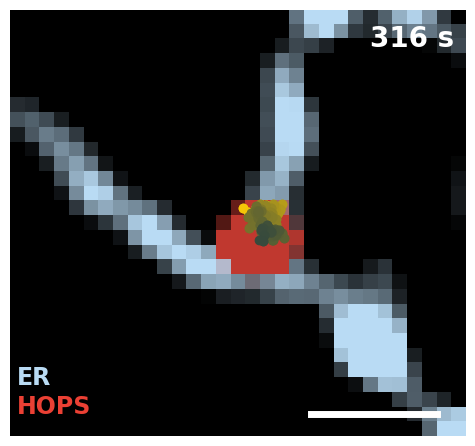

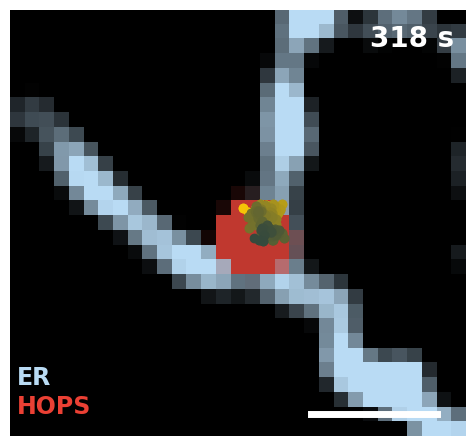

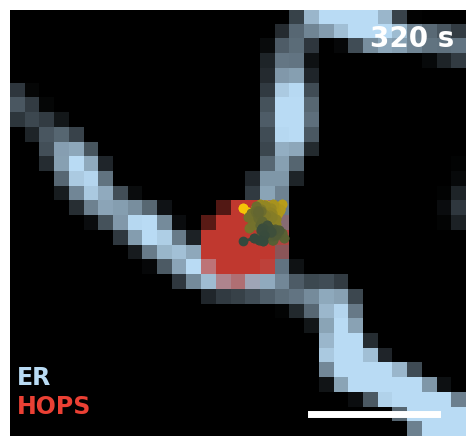

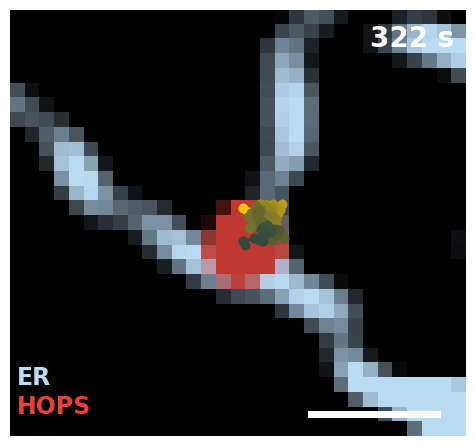

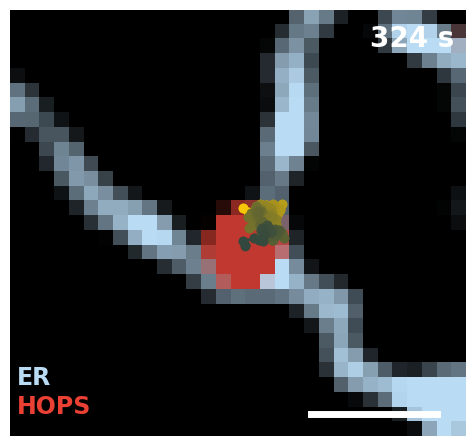

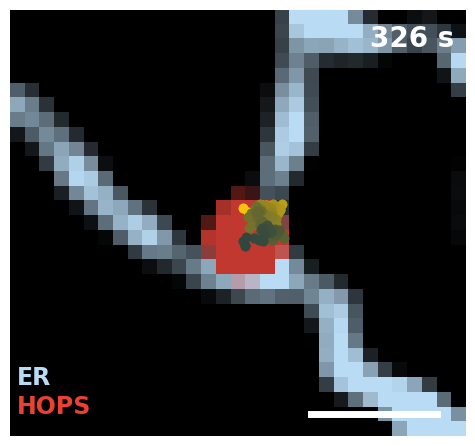

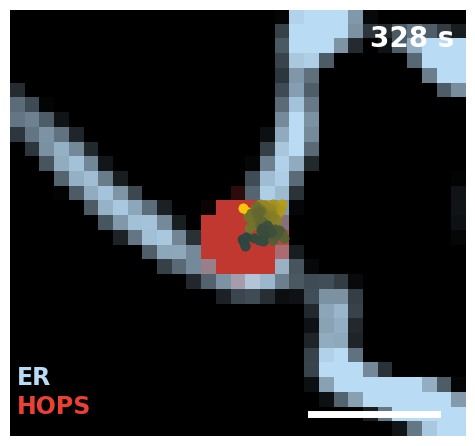

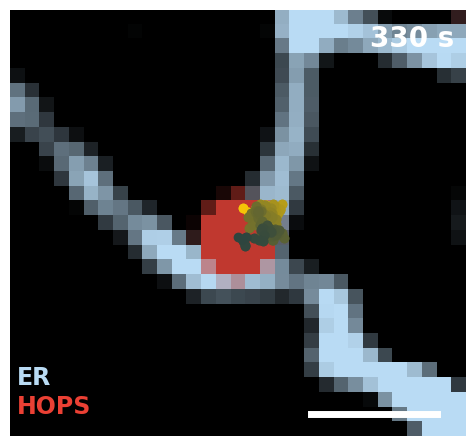

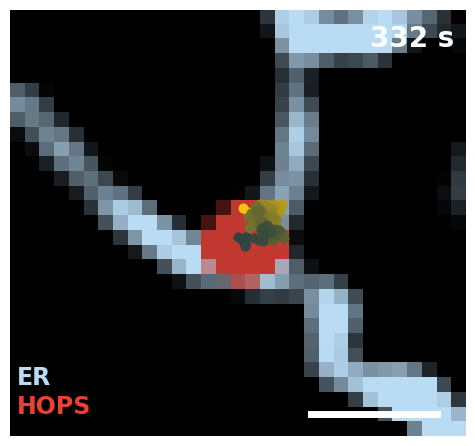

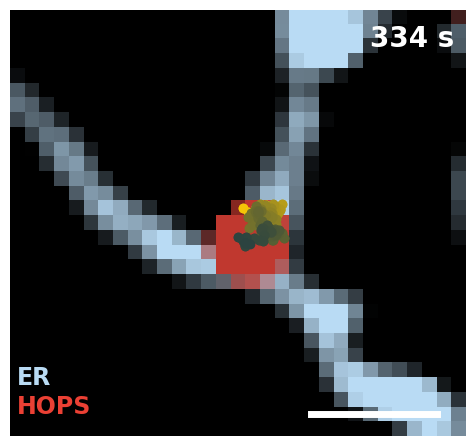

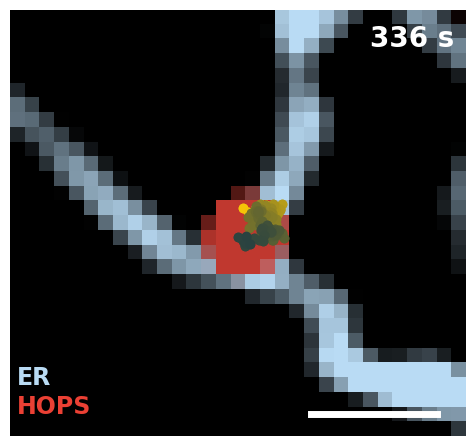

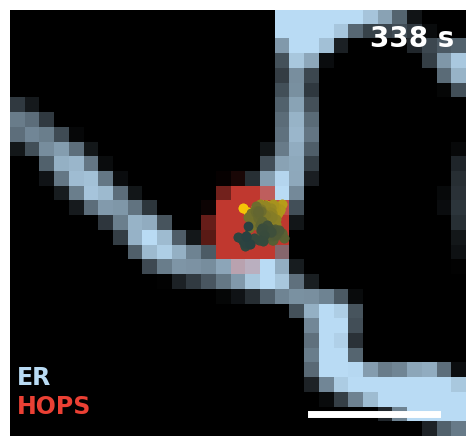

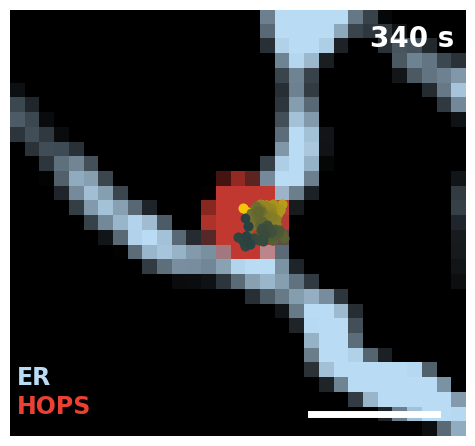

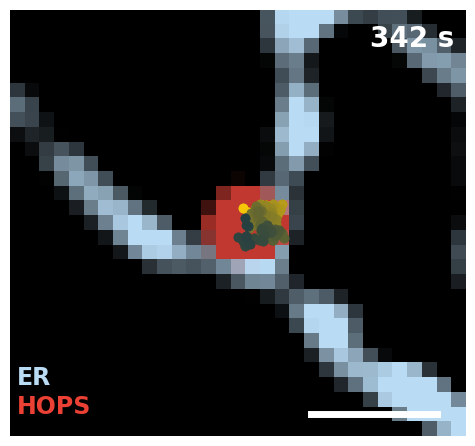

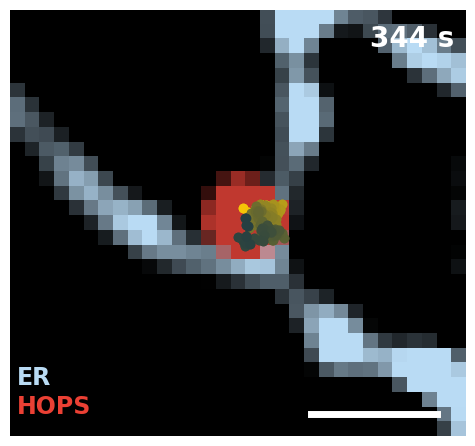

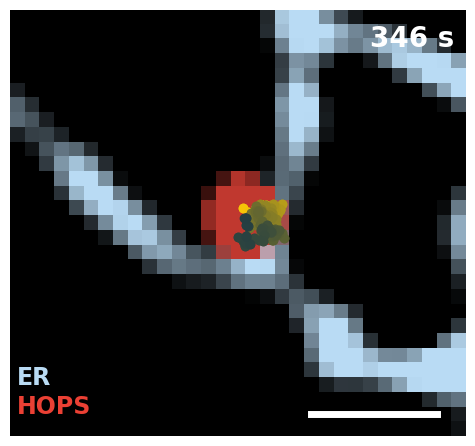

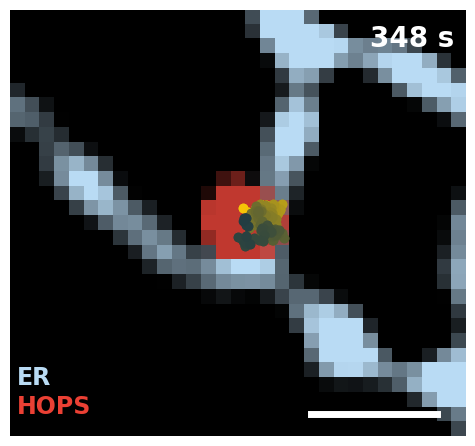

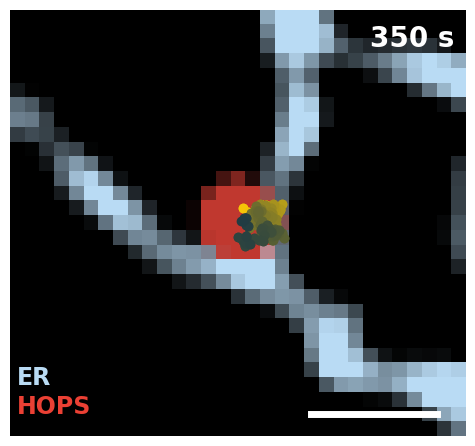

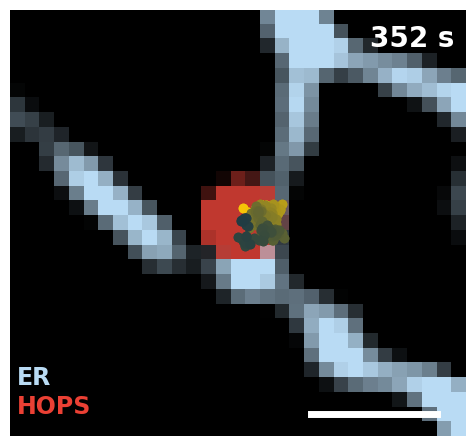

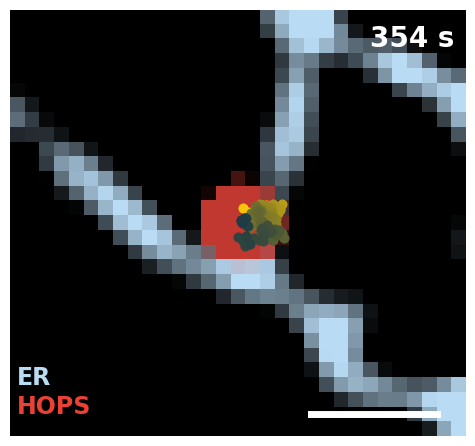

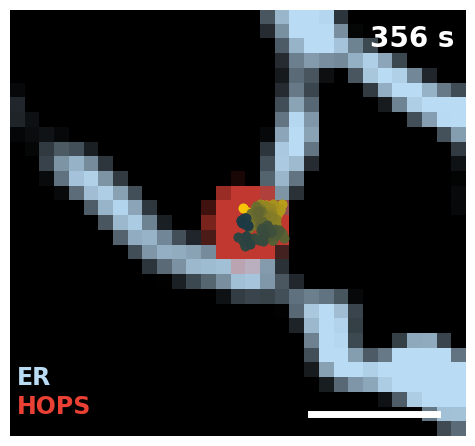

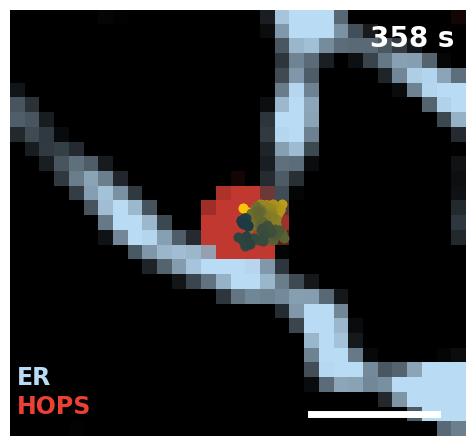

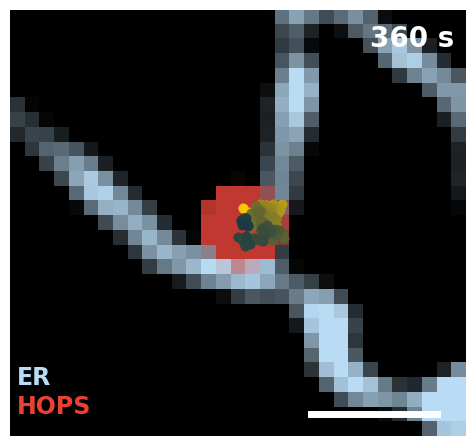

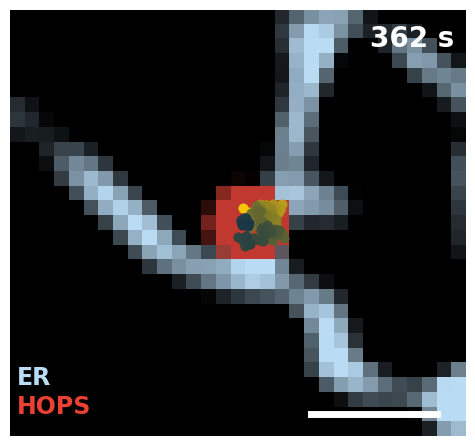

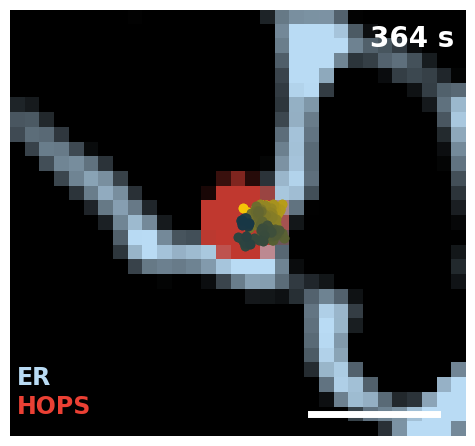

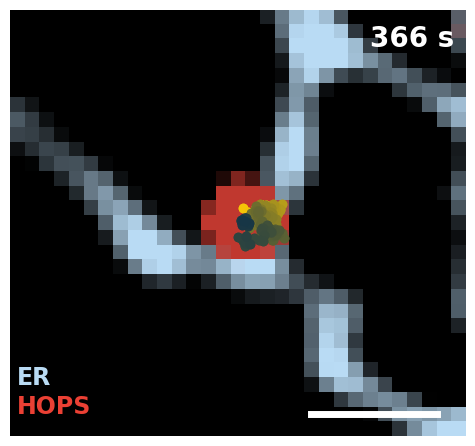

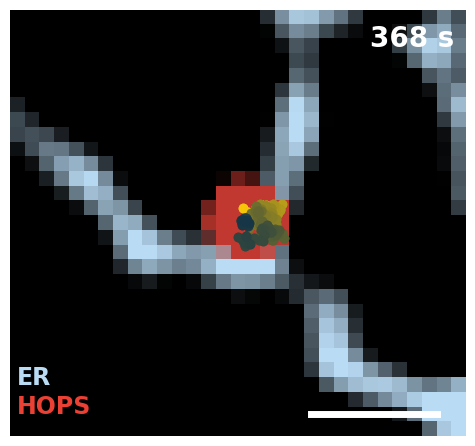

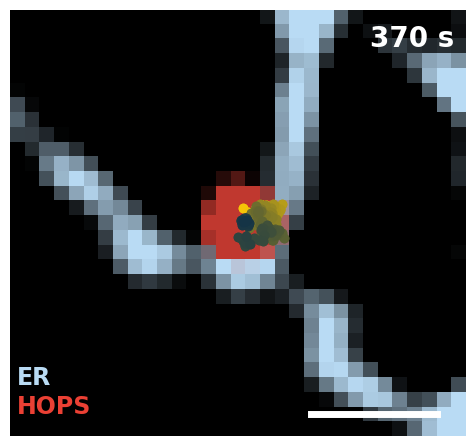

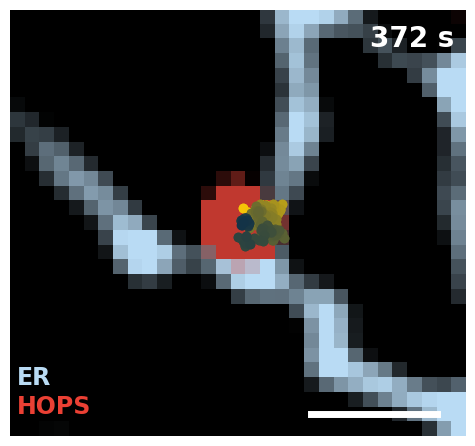

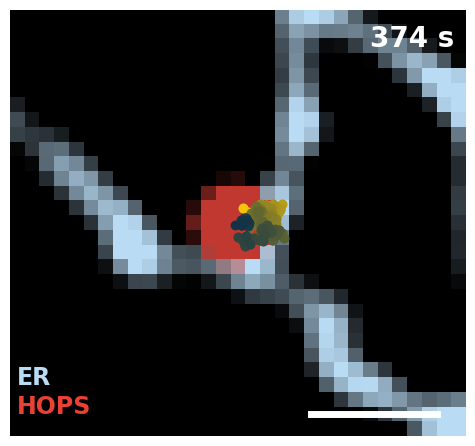

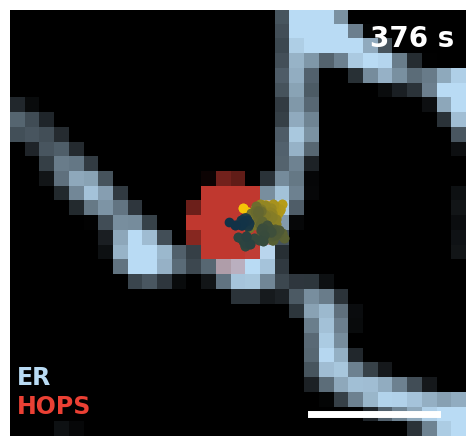

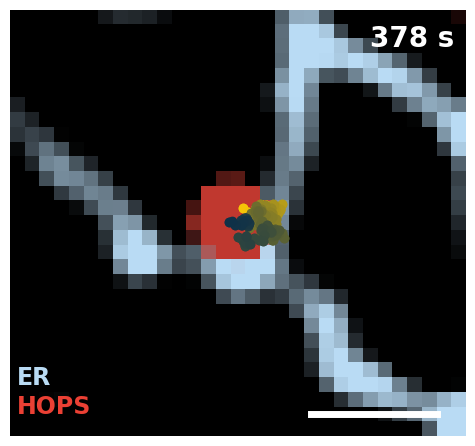

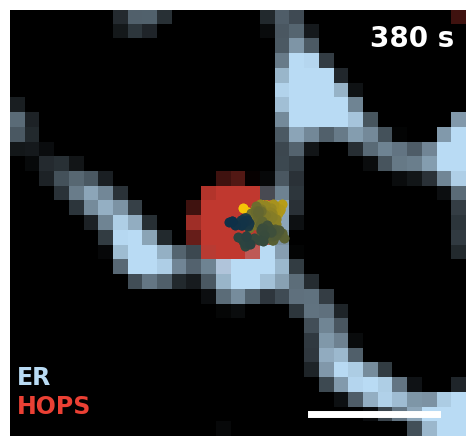

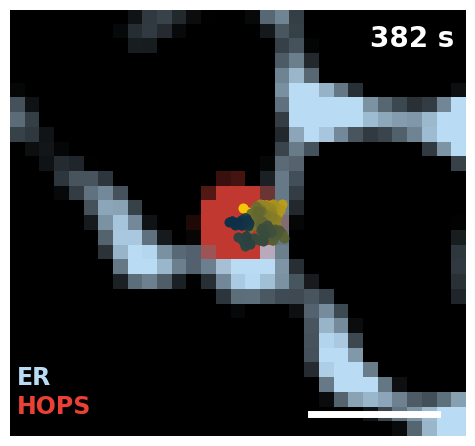

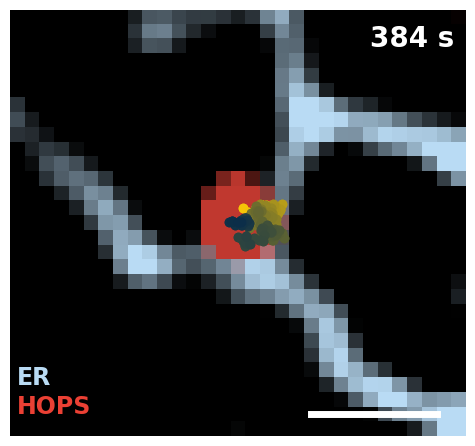

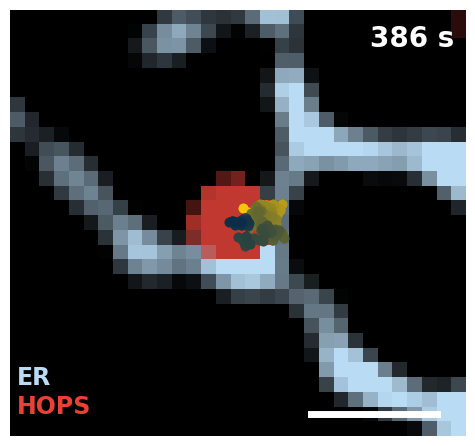

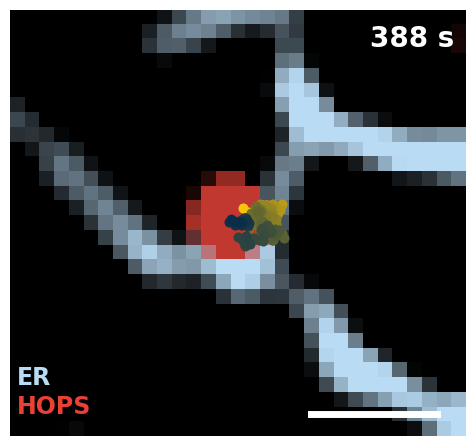

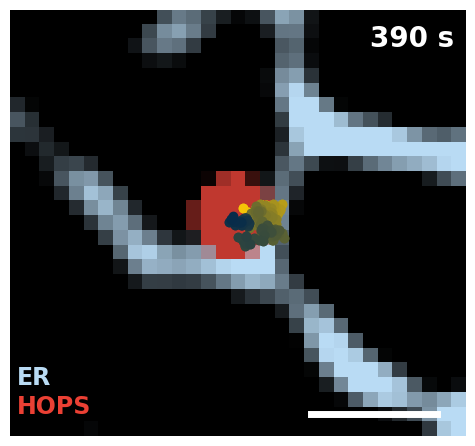

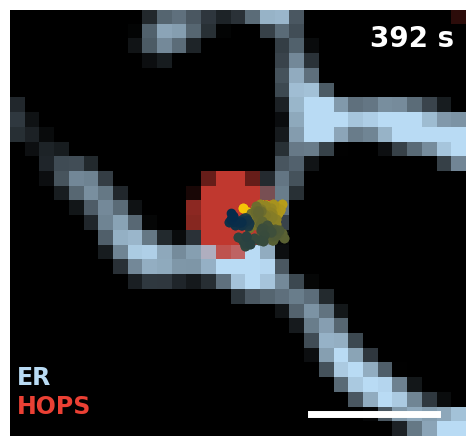

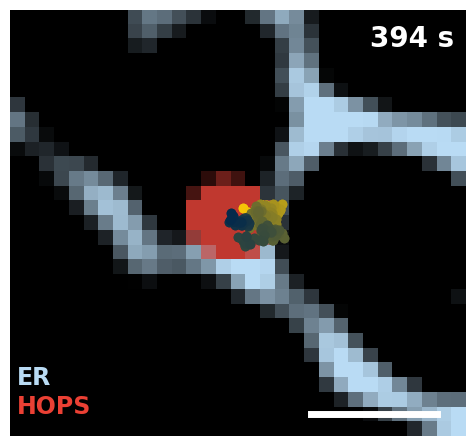

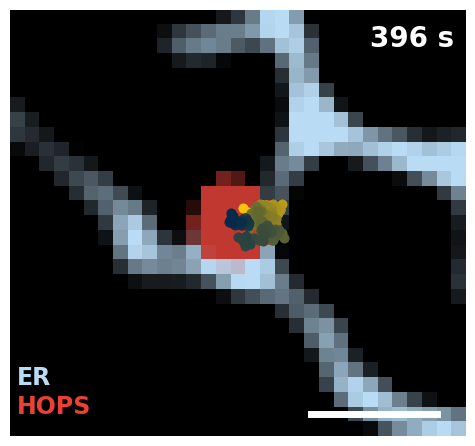

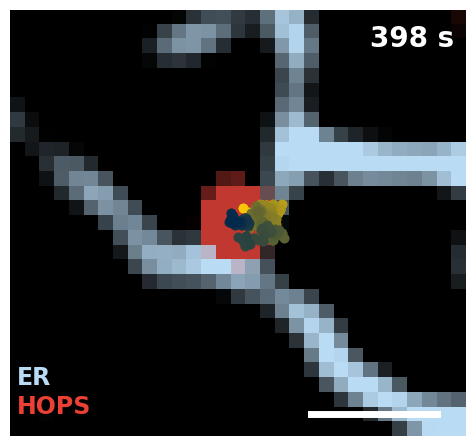

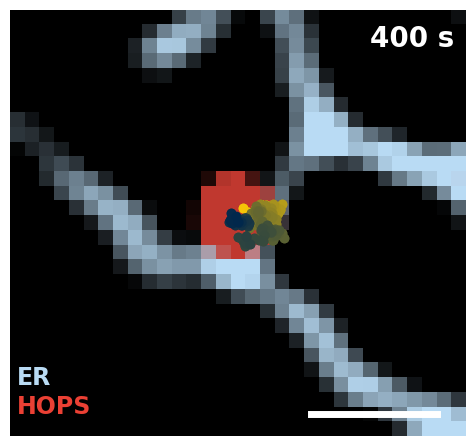

In [5]:
um_per_pixel = 0.117
s_per_frame = 2
folder_data = r"Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\HOPS_ER_dual imaging\no_drug\After bandpass filtering\Representative movies"
folder_save = folder_data

tif_filename = "20240716_UGD_ER_405_7_532_5_rep2_FOV-3_cropped_montage_merged.tif"
csv_filename = "20240716_UGD_ER_405_7_532_5_rep2_FOV-3_cropped_montage_spots_reformatted.csv"

os.chdir(folder_data)
video = imread(tif_filename)
print("Shape of video array:", video.shape)
df = pd.read_csv(csv_filename)
df = df.sort_values("t")

plow = 0.5  # imshow intensity percentile
phigh = 90
scalebar_color = "white"

cmap_blue = clr.LinearSegmentedColormap.from_list(
    "dark2blue",
    ["black", "#B9DBF4"],
)
cmap_red = clr.LinearSegmentedColormap.from_list(
    "transparent2red",
    [(0.753, 0.22, 0.188, 0), (0.753, 0.22, 0.188, 1)],
)
N = df.shape[0]
cmap = clr.LinearSegmentedColormap.from_list("maize2blue", ["#FFCB05", "#00274C"], N=N)

scalebar_length_um = 1
scalebar_length_pxl = scalebar_length_um / um_per_pixel
scale_bar_offset = 1

fig, ax = plt.subplots(1, 1)
all_avaliable_frames = set(df["t"].unique())


def animate(frame):
    ax.clear()
    img_blue = video[frame - 1, 0, :, :]
    img_red = video[frame - 1, 1, :, :]
    plt.imshow(
        img_blue,
        cmap=cmap_blue,
        vmin=50,
        vmax=500,
    )
    plt.imshow(
        img_red,
        cmap=cmap_red,
        vmin=20,
        vmax=50,
    )
    # add time stamp
    plt.text(
        24,
        26,
        str(round(frame * s_per_frame, 2)) + " s",
        color="white",
        weight="bold",
        size=20,
    )
    # add color labels
    plt.text(
        0,
        3,
        "ER",
        color="#B9DBF4",
        weight="bold",
        size=17,
    )
    plt.text(
        0,
        1,
        "HOPS",
        color="#eb4034",
        weight="bold",
        size=17,
    )

    # Add a single current circle, except for gaps
    if frame - 1 in all_avaliable_frames:
        current_x = df[df["t"] == frame - 1]["x"].squeeze()
        current_y = df[df["t"] == frame - 1]["y"].squeeze()
        c = plt.Circle(
            (current_x, current_y),
            1.3,
            color="white",
            fill=False,
            lw=2,
        )
        ax.add_patch(c)
    # Add a single track
    track = df[df["t"] <= frame - 1]
    t_plot = track["t"].to_numpy(float)
    x_plot = track["x"].to_numpy(float)
    y_plot = track["y"].to_numpy(float)
    for i in range(len(t_plot) - 1):
        plt.plot(
            x_plot[i : i + 2],
            y_plot[i : i + 2],
            "-o",
            color=cmap(i / N),
            lw=2,
        )
    # scale bar
    scale_bar_offset = 0
    scalebar_length_um = 1
    base_x = 20
    base_y = 1
    scalebar_length_pxl = scalebar_length_um / um_per_pixel
    plt.plot(
        [
            base_x + scale_bar_offset,
            base_x + scale_bar_offset + scalebar_length_pxl,
        ],
        [base_y + scale_bar_offset, base_y + scale_bar_offset],
        "-",
        color="white",
        lw=5,
    )
    plt.xlim(0, img_blue.shape[0])
    plt.ylim(0, img_blue.shape[1])
    ax.invert_yaxis()
    plt.tight_layout()
    plt.axis("scaled")
    plt.axis("off")

# animate(5)
# ani = FuncAnimation(fig, animate, frames=150, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=25)  # 25 Hz, 0.5x playback (original:50Hz)
# ani.save(join(folder_save, "VideoS_RNA_escape.mp4"), writer=writer, dpi=600)

# Create montage images
num_frames = 200
for frame in range(1,num_frames+1):
    animate(frame)
    plt.savefig(join(folder_save, f"frame_{frame:03d}.png"), dpi = 600)
    plt.show()

plt.close(fig)

#Create animated video
# ani = FuncAnimation(fig, animate, frames=200, interval=20, repeat=False)
# writer = animation.FFMpegWriter(fps=20)  # 20 Hz
# ani.save(join(folder_save, "VideoS_HOPS_Cofinement_ER.mp4"), writer=writer, dpi=600)